<div style="border: 1px solid black; padding: 10px;">
<table>
<tr>
    <td width=20%>
        <br/> <a style="font-size: 16px; font-weight: italic"> Data Scientist Junior </a> <br/> <br/> Théo JEAN <br/>
    </td>
    <td width=60%>
        <center>
            <h1>Bank attrition analysis</h1>
            <h2> <font color='red'> What type of customer is likely to change bank?</font> </h2>
        </center>
    </td>
    <td width=20%>
        <a style="font-size: 16px; font-weight: bold"> Personal project 1 </a>
         <br/> 07/04/2024 <br/>
    </td>
</tr>
</table>
</div>

https://www.kaggle.com/datasets/manjuahuja/bank-churner

# Objective : 

Maximise f1_score, we want to recognise as much as possible all the attrited customers

Développer une app streamlit permettant de fournir des caractéristiques de clients et qui offre des analyses statistiques dessus + la prédiction d'attrition. 

En termes de contenu :
- Statistiques descriptives
- Modélisation et optimisation avec GridSearch + Optuna
- OOP pour l'EDA et pipeline
- Comparaison avec du DL
- Une map folium
- Affichage des résultats en dynamique comme sur Optuna pour l'entrainement

A faire : 
- Quid de la corrélation ?
- Amélio modèle

# First overview of the dataset :

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimpy import skim
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_curve, auc, accuracy_score, make_scorer, precision_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_curve
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("BankChurners.csv", sep=",")

In [3]:
df.head()

CLIENTNUM     Attrition_Flag  Customer_Age Gender  Dependent_count  \
0  768805383  Existing Customer            45      M                3   
1  818770008  Existing Customer            49      F                5   
2  713982108  Existing Customer            51      M                3   
3  769911858  Existing Customer            40      F                4   
4  709106358  Existing Customer            40      M                3   

  Education_Level Marital_Status Income_Category Card_Category  \
0     High School        Married     $60K - $80K          Blue   
1        Graduate         Single  Less than $40K          Blue   
2        Graduate        Married    $80K - $120K          Blue   
3     High School        Unknown  Less than $40K          Blue   
4      Uneducated        Married     $60K - $80K          Blue   

   Months_on_book  ...  Credit_Limit  Total_Revolving_Bal  Avg_Open_To_Buy  \
0              39  ...       12691.0                  777          11914.0   
1              44  ...        8256.0                  864           7392.0   
2              36  ...        3418.0                    0           3418.0   
3              34  ...        3313.0                 2517            796.0   
4              21  ...        4716.0                    0           4716.0   

   Total_Amt_Chng_Q4_Q1  Total_Trans_Amt  Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  \
0                 1.335             1144              42                1.625   
1                 1.541             1291              33                3.714   
2                 2.594             1887              20                2.333   
3                 1.405             1171              20                2.333   
4                 2.175              816              28                2.500   

   Avg_Utilization_Ratio  \
0                  0.061   
1                  0.105   
2                  0.000   
3                  0.760   
4                  0.000   

   Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1  \
0                                           0.000093                                                                                    
1                                           0.000057                                                                                    
2                                           0.000021                                                                                    
3                                           0.000134                                                                                    
4                                           0.000022                                                                                    

   Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2  
0                                            0.99991                                                                                   
1                                            0.99994                                                                                   
2                                            0.99998                                                                                   
3                                            0.99987                                                                                   
4                                            0.99998                                                                                   

[5 rows x 23 columns]

In [4]:
df = df.iloc[:, 1:-2] # deletion of last two columns not required for analysis and the first

In [118]:
df.dtypes

Attrition_Flag               object
Customer_Age                  int64
Gender                       object
Dependent_count               int64
Education_Level              object
Marital_Status               object
Income_Category              object
Card_Category                object
Months_on_book                int64
Total_Relationship_Count      int64
Months_Inactive_12_mon        int64
Contacts_Count_12_mon         int64
Credit_Limit                float64
Total_Revolving_Bal           int64
Avg_Open_To_Buy             float64
Total_Amt_Chng_Q4_Q1        float64
Total_Trans_Amt               int64
Total_Trans_Ct                int64
Total_Ct_Chng_Q4_Q1         float64
Avg_Utilization_Ratio       float64
dtype: object

### **DESCRIPTION DES VARIABLES :**

**CLIENTNUM** : Quantitative, identifiant du client 

**Attribution_Flag** : Qualitative, toujours client ou pas

**Customer_Age** : Quantitative, age du client

**Gender** : Qualitative, sexe du client

**Dependent_count** : Quantitative, nombre de compte du client

**Education_level** : Qualitative, niveau d'éducation du client

**Marital_Status** : Qualitative, situation amoureuse du client

**Income_category** : Qualitative, tranche de revenue du client

**Card_Category** : Qualitative, type de carte de crédit du client

**Months_on_book** : Quantitative, période en mois où le client est avec cette banque

**Total_Relationship_Count** : Quantitative, nombre total de produits détenus par le client

**Months_Inactive_12_mon** : Quantitative, Nombre de mois inactifs au cours des 12 derniers mois

**Contacts_Count_12_mon** : Quantitative, Nombre de contacts avec la banque au cours des 12 derniers mois

**Credit_Limit** : Quantitative, plafond bancaire du client

**Total_Revolving_Bal** : Quantitative, Total du crédit renouvelable actuel

**Avg_Open_To_Buy**: Quantitative, Moyenne sur les 12 derniers mois du montant qu'il restait à dépenser en fin de mois

**Total_Amt_Chng_Q4_Q1** : Quantitative, Variation du montant des transactions (T4 par rapport au T1)

**Total_Trans_Amt** : Quantitative, Montant total des transactions (12 derniers mois)

**Total_Trans_Ct** : Quantitative, Nombre total de transactions (12 derniers mois)

**Total_Ct_Chng_Q4_Q1** : Quantitative, Variation du nombre d’opérations (T4 par rapport au T1)

**Avg_Utilization_Ratio** : Quantitative, Taux moyen d'utilisation des cartes

In [189]:
convert_col = ['Attrition_Flag', 'Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category' ]

for col in convert_col:
    df[col] = df[col].astype('category')

In [131]:
skim(df)
print('This dataframe contains', len(df), 'obs and', len(df.columns), 'columns')

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types               Categories                                        │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓ ┏━━━━━━━━━━━━━━━━━━━━━━━┓                                │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃ ┃ Categorical Variables ┃                                │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩ ┡━━━━━━━━━━━━━━━━━━━━━━━┩                                │
│ │ Number of rows    │ 10127  │ │ int64       │ 9     │ │ Attrition_Flag        │                                │
│ │ Number of columns │ 20     │ │ category    │ 6     │ │ Gender                │                                │
│ └───────────────────┴────────┘ │ float64     │ 5     │ │ Education_Level       │                                │
│                                └─────────────┴───────┘ │ Marital_Status        │                                │
│                                                        │ Income_Category       │                                │
│                                                        │ Card_Category         │                                │
│                                                        └───────────────────────┘                                │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name              ┃ NA  ┃ NA %  ┃ mean  ┃ sd    ┃ p0    ┃ p25    ┃ p50   ┃ p75    ┃ p100   ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━┩  │
│ │ Customer_Age             │   0 │     0 │    46 │     8 │    26 │     41 │    46 │     52 │     73 │ ▁▅▇▆▂  │  │
│ │ Dependent_count          │   0 │     0 │   2.3 │   1.3 │     0 │      1 │     2 │      3 │      5 │ ▃▅▇▇▅▁ │  │
│ │ Months_on_book           │   0 │     0 │    36 │     8 │    13 │     31 │    36 │     40 │     56 │ ▁▂▃▇▃▁ │  │
│ │ Total_Relationship_Count │   0 │     0 │   3.8 │   1.6 │     1 │      3 │     4 │      5 │      6 │ ▃▅▇▇▇▆ │  │
│ │ Months_Inactive_12_mon   │   0 │     0 │   2.3 │     1 │     0 │      2 │     2 │      3 │      6 │  ▅▇▇▁▁ │  │
│ │ Contacts_Count_12_mon    │   0 │     0 │   2.5 │   1.1 │     0 │      2 │     2 │      3 │      6 │ ▁▃▇▇▃▁ │  │
│ │ Credit_Limit             │   0 │     0 │  8600 │  9100 │  1400 │   2600 │  4500 │  11000 │  35000 │ ▇▂▁▁ ▁ │  │
│ │ Total_Revolving_Bal      │   0 │     0 │  1200 │   810 │     0 │    360 │  1300 │   1800 │   2500 │ ▇▂▅▇▅▅ │  │
│ │ Avg_Open_To_Buy          │   0 │     0 │  7500 │  9100 │     3 │   1300 │  3500 │   9900 │  35000 │ ▇▂▁▁ ▁ │  │
│ │ Total_Amt_Chng_Q4_Q1     │   0 │     0 │  0.76 │  0.22 │     0 │   0.63 │  0.74 │   0.86 │    3.4 │   ▁▇   │  │
│ │ Total_Trans_Amt          │   0 │     0 │  4400 │  3400 │   510 │   2200 │  3900 │   4700 │  18000 │ ▇▇▁ ▁  │  │
│ │ Total_Trans_Ct           │   0 │     0 │    65 │    23 │    10 │     45 │    67 │     81 │    140 │ ▂▆▇▇▂▁ │  │
│ │ Total_Ct_Chng_Q4_Q1      │   0 │     0 │  0.71 │  0.24 │     0 │   0.58 │   0.7 │   0.82 │    3.7 │   ▃▇   │  │
│ │ Avg_Utilization_Ratio    │   0 │     0 │  0.27 │  0.28 │     0 │  0.023 │  0.18 │    0.5 │      1 │ ▇▂▂▂▂▁ │  │
│ └──────────────────────────┴─────┴───────┴───────┴───────┴───────┴────────┴───────┴────────┴────────┴────────┘  │
│                                                    category                                                     │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                             ┃ NA       ┃ NA %         ┃ ordered             ┃ unique           ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇

This dataframe contains 10127 obs and 20 columns


Target value : **Attrition_Flag**

**RESUME STATISTIQUES DESCRIPTIVES / PROFIL DES CLIENTS DE LA BANQUE :**

Profil démographique : 
- La majorité des clients ont un âge compris entre 41 et 52 ans, avec une médiane de 46 ans.
- La plupart des clients ont entre 1 et 3 personnes à charge, avec une médiane de 2.3.
- En moyenne, les clients sont clients depuis 36 mois, avec la plupart des clients ayant entre 31 et 40 mois d'ancienneté.

Engagement et relation avec la banque :

- Les clients détiennent en moyenne 3.8 produits bancaires.
- En moyenne, les clients ont été inactifs pendant 2.3 mois au cours des 12 derniers mois.
- Les clients ont eu en moyenne 2.5 contacts avec la banque au cours des 12 derniers mois.

Santé financière :

- La limite de crédit à la consommation en moyenne des clients se situe autour de 8600, avec une variation significative.
- La plupart des clients ont un solde renouvelable entre 360 et 1800.
- En moyenne, les clients ont un montant ouvert à l'achat entre 1300 et 9900.

Comportement financier :

- Le changement total du montant au cours du quatrième trimestre par rapport au premier trimestre est en moyenne de 0.76.
- La plupart des clients ont un montant total de transaction entre 2200 et 4700.
- En moyenne, les clients ont entre 45 et 81 transactions.

In [132]:
df.duplicated().any() # any duplicated obs verification 

False

In [133]:
# Let's check for missing hidden values in categorical variables

for col in df.select_dtypes(include='category').columns:
    print(f'{col.ljust(30, "-")} : {df[col].unique()}')

Attrition_Flag---------------- : ['Existing Customer', 'Attrited Customer']
Categories (2, object): ['Attrited Customer', 'Existing Customer']
Gender------------------------ : ['M', 'F']
Categories (2, object): ['F', 'M']
Education_Level--------------- : ['High School', 'Graduate', 'Uneducated', 'Unknown', 'College', 'Post-Graduate', 'Doctorate']
Categories (7, object): ['College', 'Doctorate', 'Graduate', 'High School', 'Post-Graduate', 'Uneducated', 'Unknown']
Marital_Status---------------- : ['Married', 'Single', 'Unknown', 'Divorced']
Categories (4, object): ['Divorced', 'Married', 'Single', 'Unknown']
Income_Category--------------- : ['$60K - $80K', 'Less than $40K', '$80K - $120K', '$40K - $60K', '$120K +', 'Unknown']
Categories (6, object): ['$120K +', '$40K - $60K', '$60K - $80K', '$80K - $120K', 'Less than $40K', 'Unknown']
Card_Category----------------- : ['Blue', 'Gold', 'Silver', 'Platinum']
Categories (4, object): ['Blue', 'Gold', 'Platinum', 'Silver']


We can see that in `Education_Level`, `Marital_Status` and `Income_Category` there are Unknown values

In [134]:
unknown_col = ['Education_Level', 'Marital_Status', 'Income_Category']

for col in unknown_col:
    print(f"{col} : {len(df[df[col] == 'Unknown'])}")
    print(round((df[col] == 'Unknown').mean() * 100, 2),'%')
    print('-----')

Education_Level : 1519
15.0 %
-----
Marital_Status : 749
7.4 %
-----
Income_Category : 1112
10.98 %
-----


# 1. Exploratory Data Analysis (EDA)

## 1.1. Variables qualitatives:

In [137]:
string_columns = df.select_dtypes(include=['category'])

for i in string_columns.columns:
    print(f"Décompte des valeurs pour la colonne '{i}':")
    print(string_columns[i].value_counts().to_string(), end="\n\n")

Décompte des valeurs pour la colonne 'Attrition_Flag':
Attrition_Flag
Existing Customer    8500
Attrited Customer    1627

Décompte des valeurs pour la colonne 'Gender':
Gender
F    5358
M    4769

Décompte des valeurs pour la colonne 'Education_Level':
Education_Level
Graduate         3128
High School      2013
Unknown          1519
Uneducated       1487
College          1013
Post-Graduate     516
Doctorate         451

Décompte des valeurs pour la colonne 'Marital_Status':
Marital_Status
Married     4687
Single      3943
Unknown      749
Divorced     748

Décompte des valeurs pour la colonne 'Income_Category':
Income_Category
Less than $40K    3561
$40K - $60K       1790
$80K - $120K      1535
$60K - $80K       1402
Unknown           1112
$120K +            727

Décompte des valeurs pour la colonne 'Card_Category':
Card_Category
Blue        9436
Silver       555
Gold         116
Platinum      20



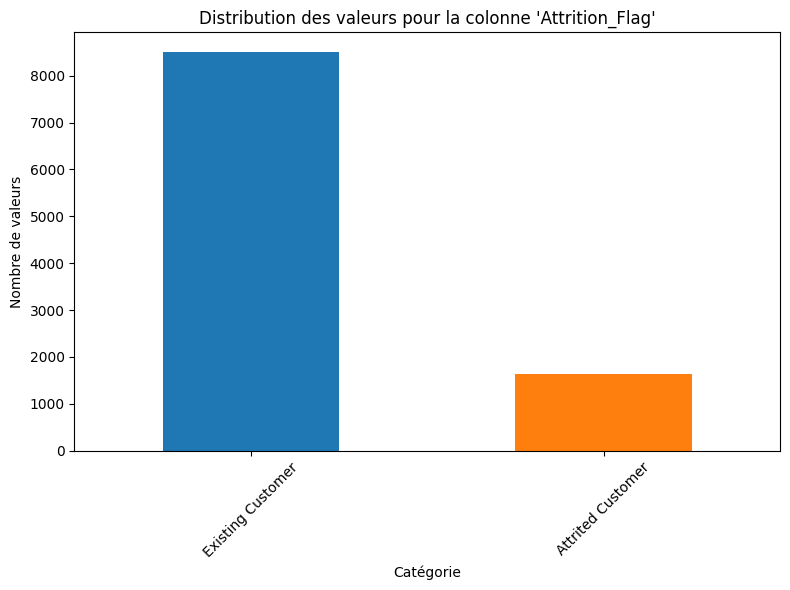

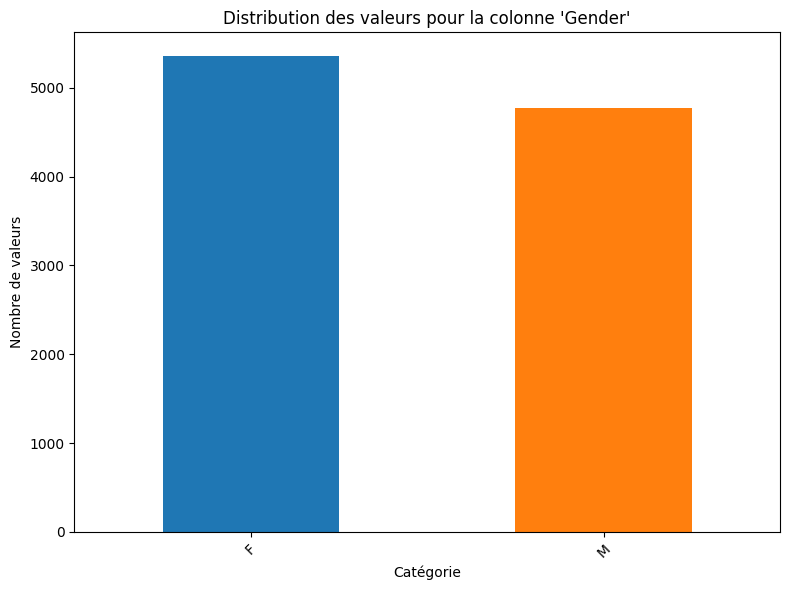

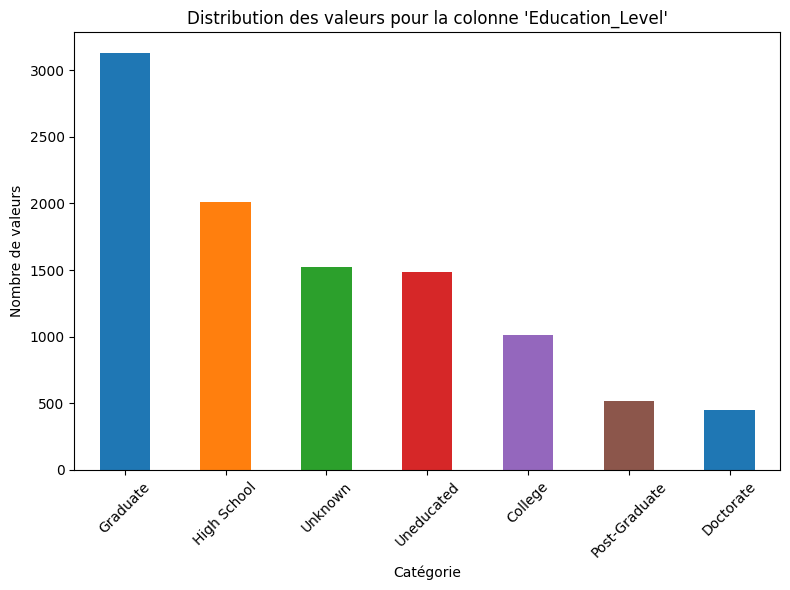

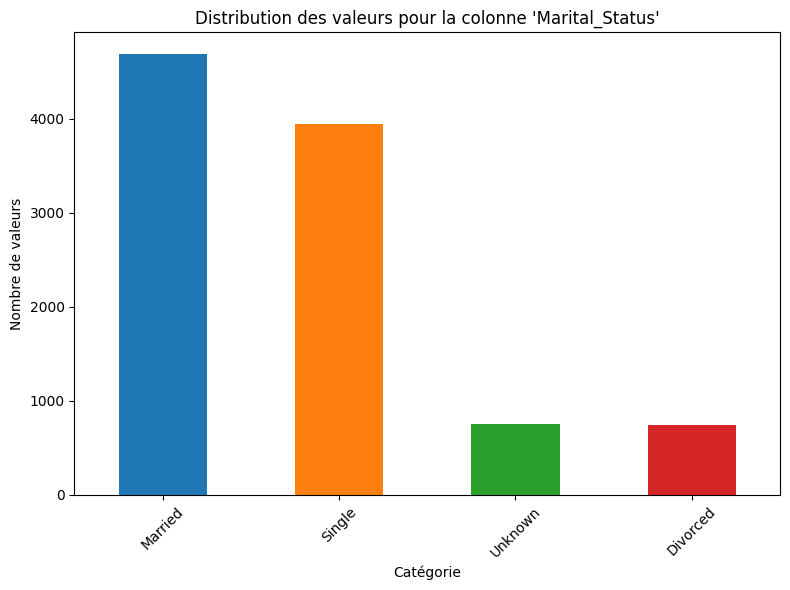

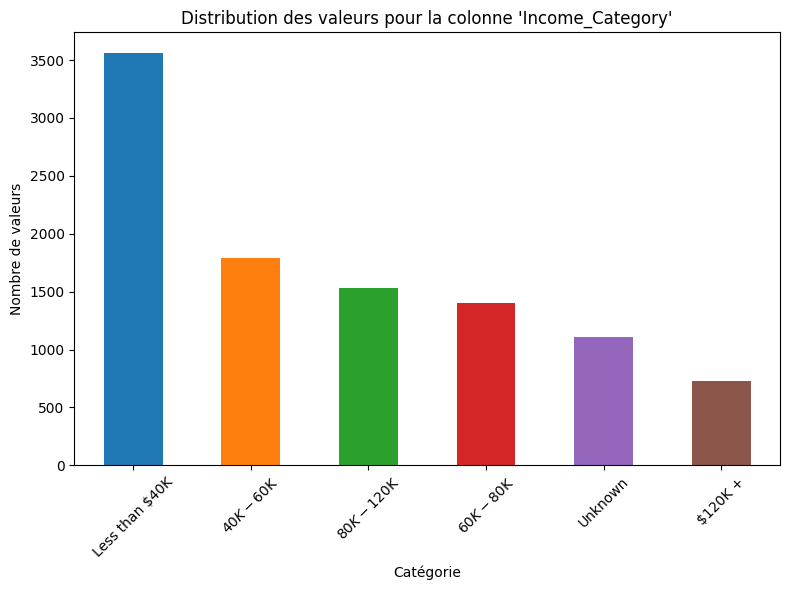

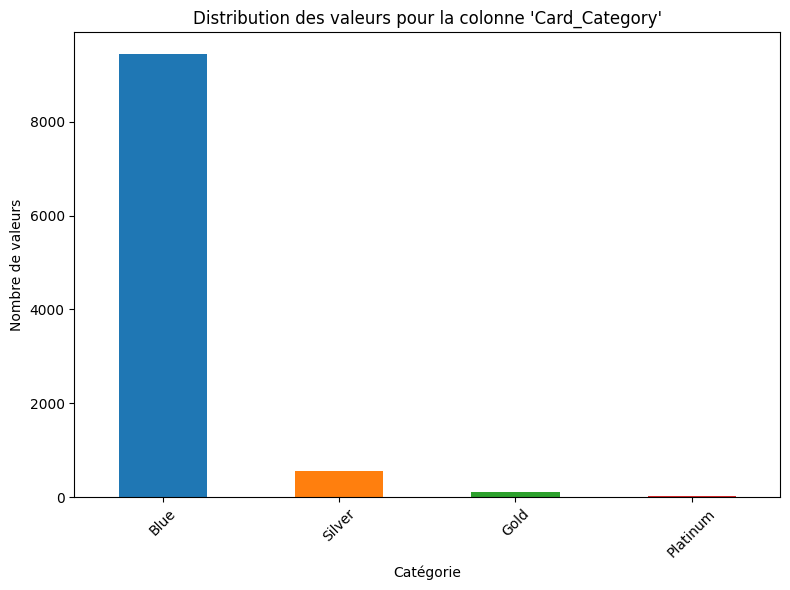

In [18]:
custom_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

# Itération sur les colonnes de type string et affichage des graphiques
for col in string_columns.columns:
    plt.figure(figsize=(8, 6))
    df[col].value_counts().plot(kind='bar', color=custom_colors)
    plt.title(f"Distribution des valeurs pour la colonne '{col}'")
    plt.xlabel('Catégorie')
    plt.ylabel('Nombre de valeurs')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## 1.2. Variables quantitatives :

In [19]:
numeric_columns = df.select_dtypes(include=['int64', 'float64'])

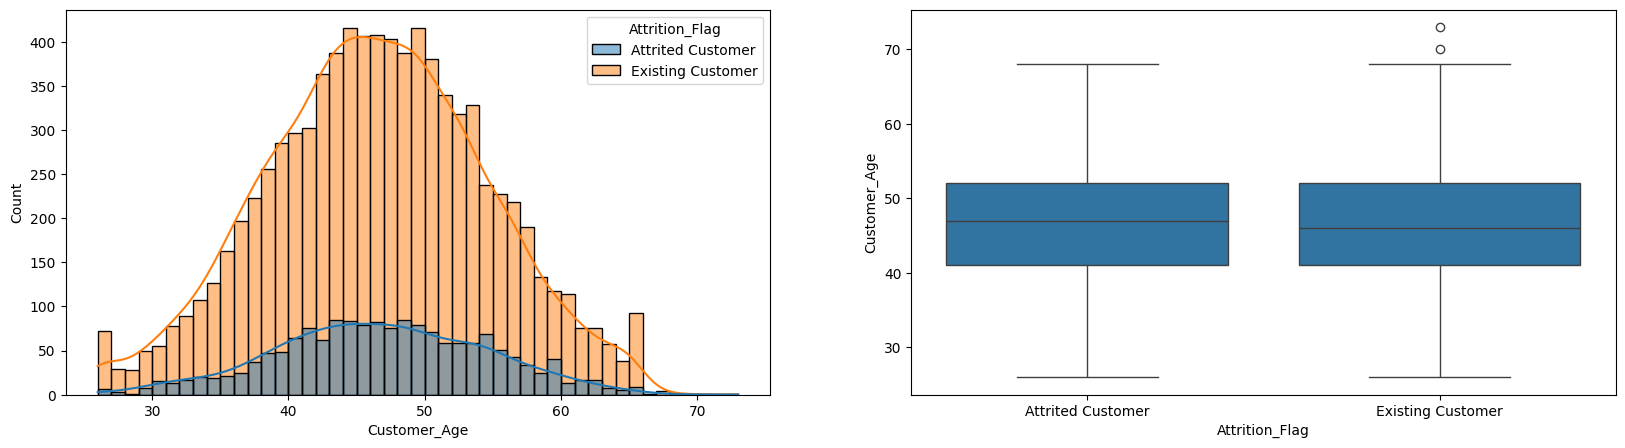

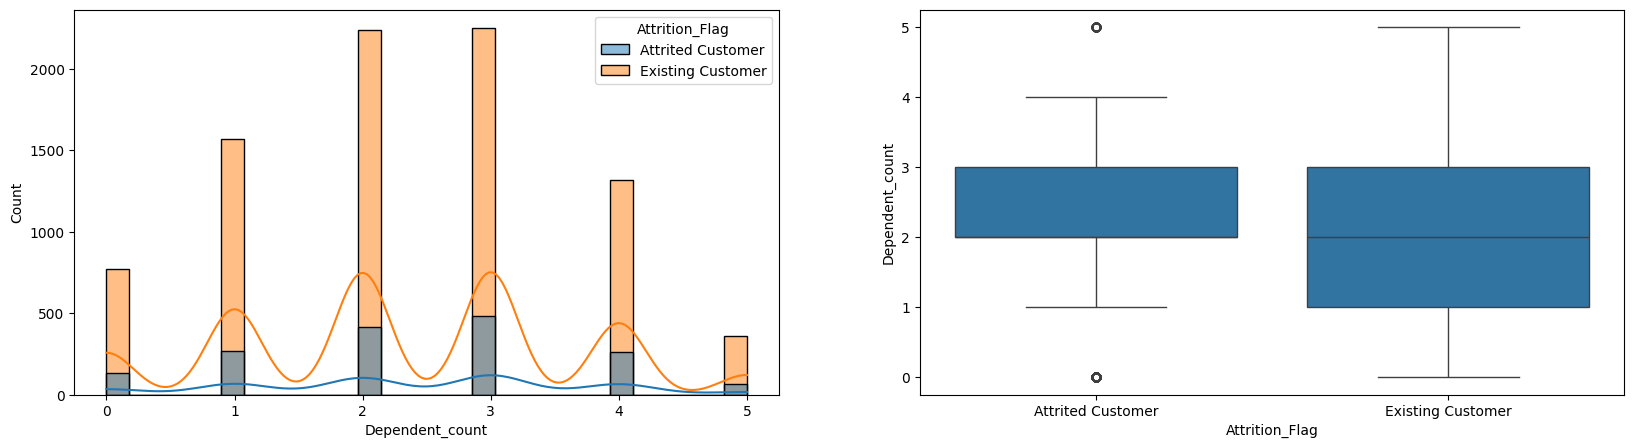

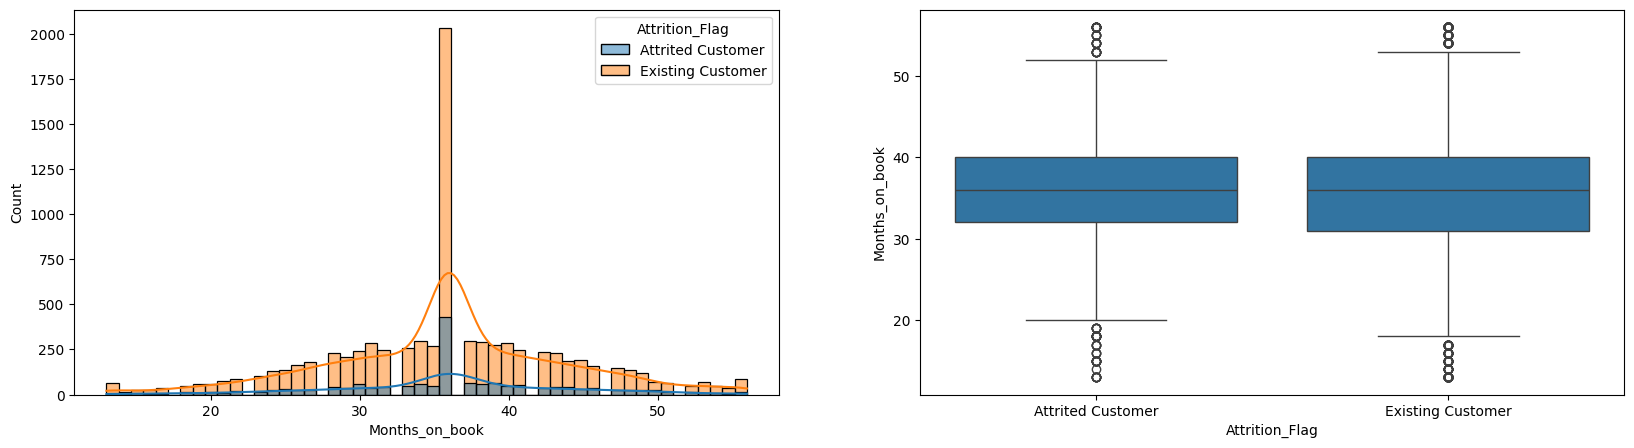

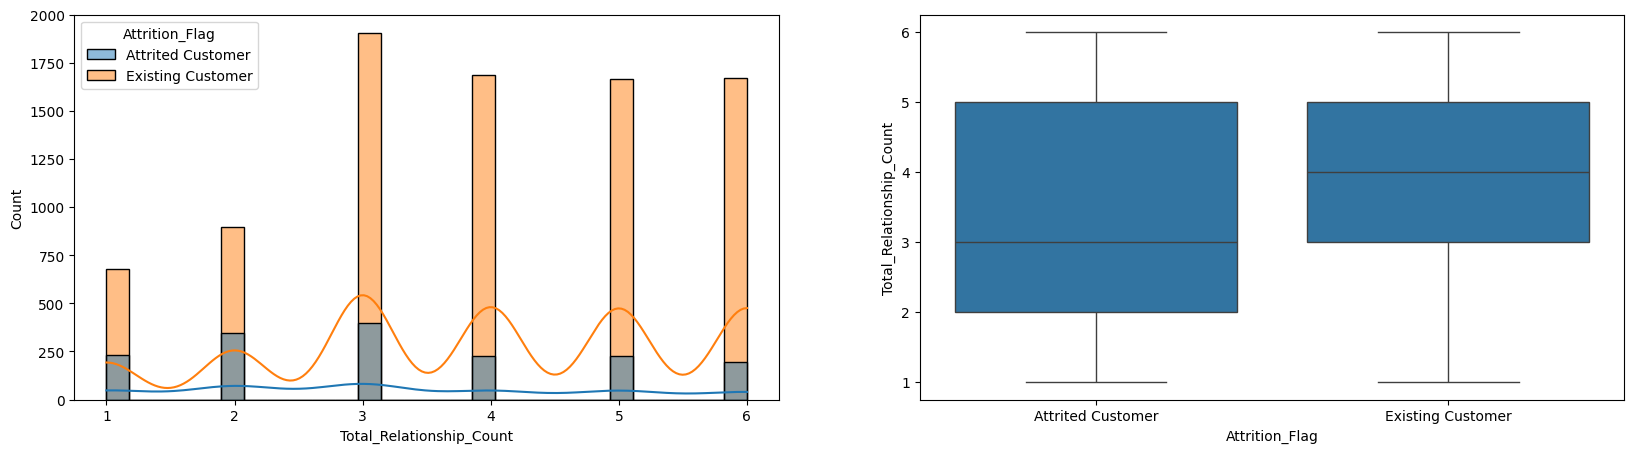

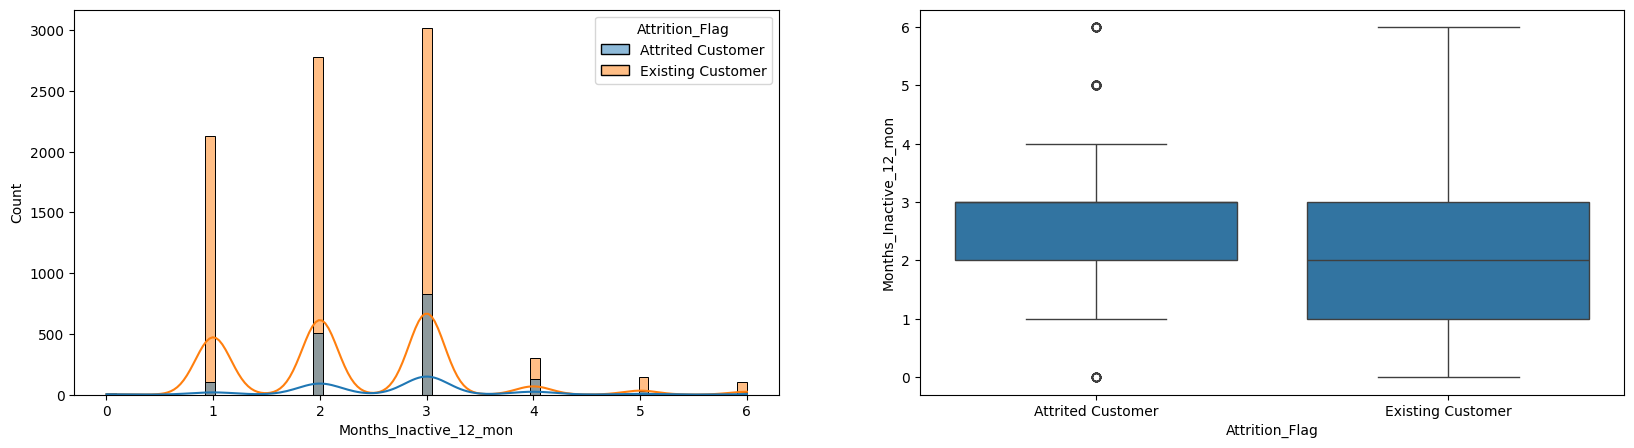

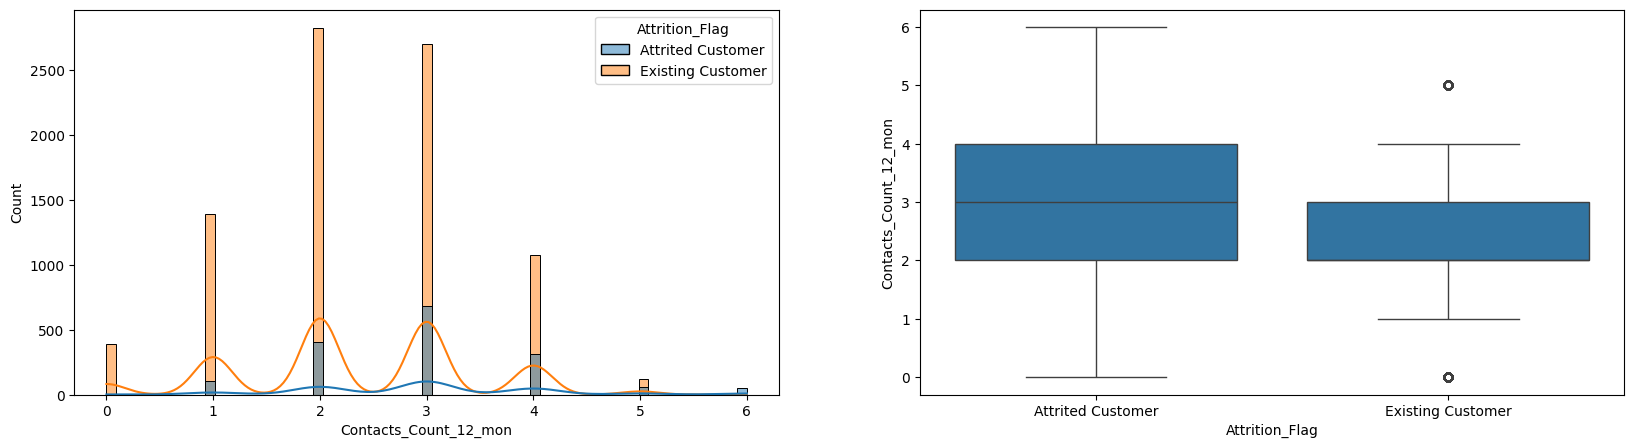

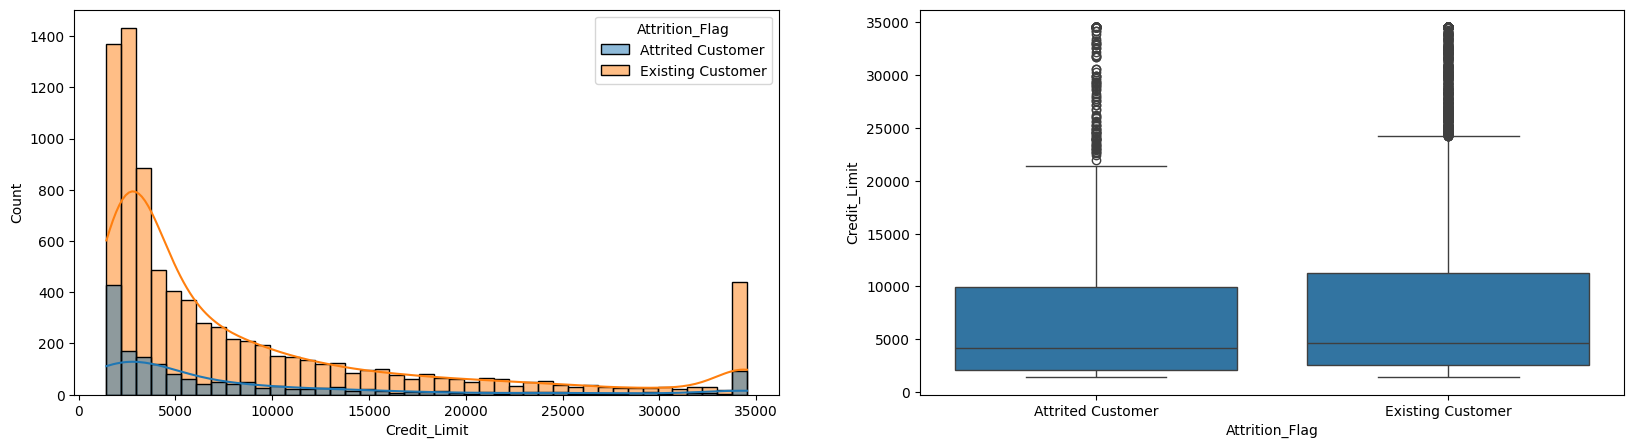

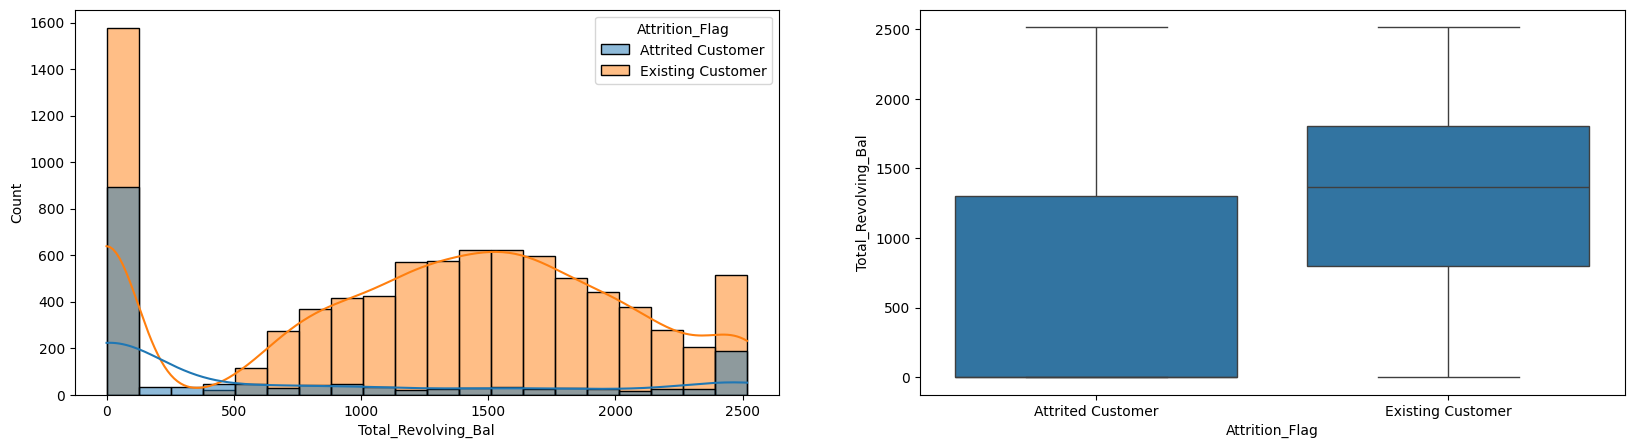

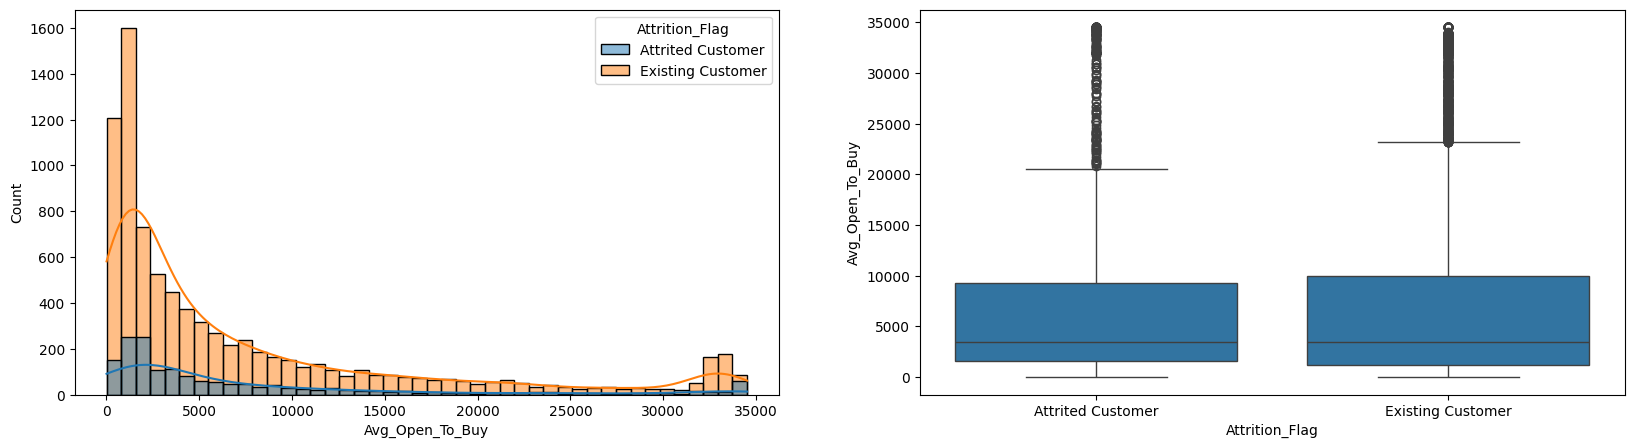

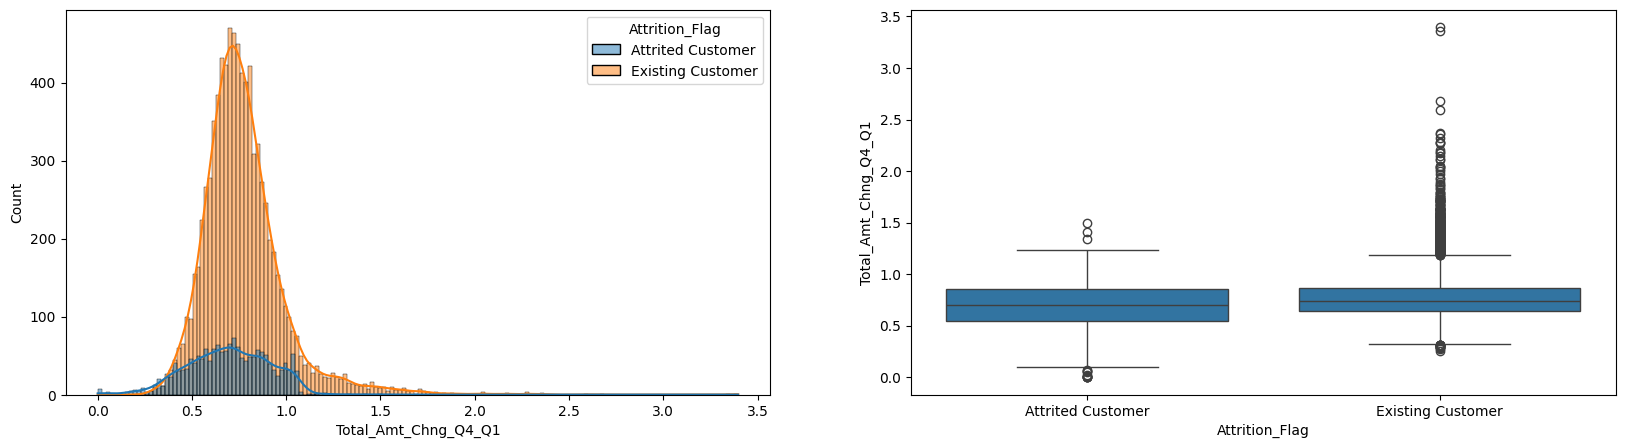

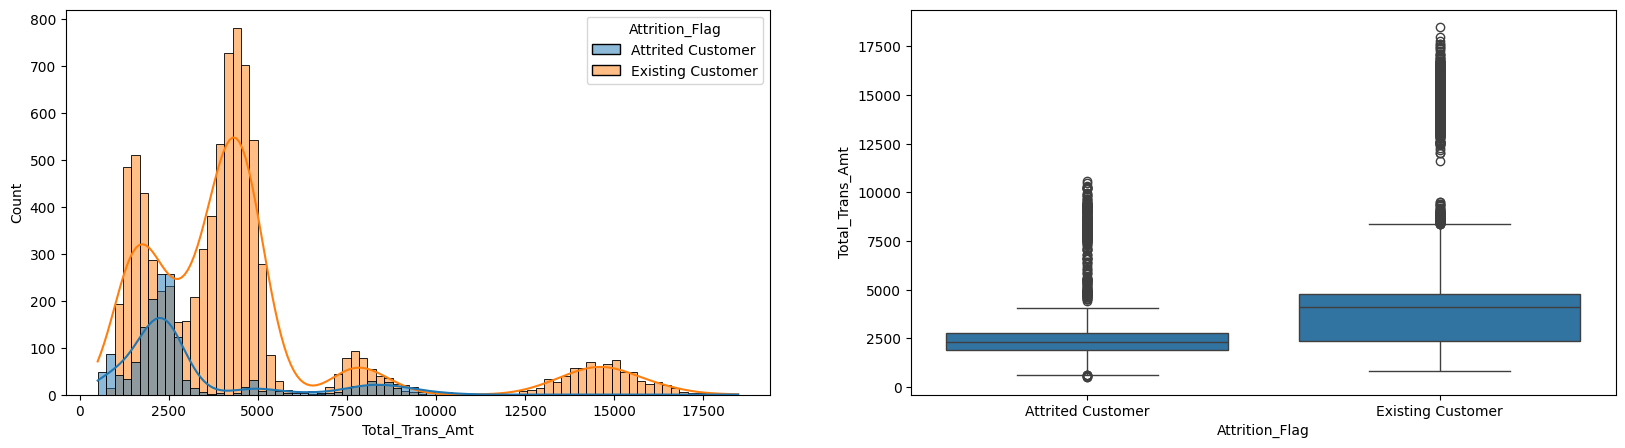

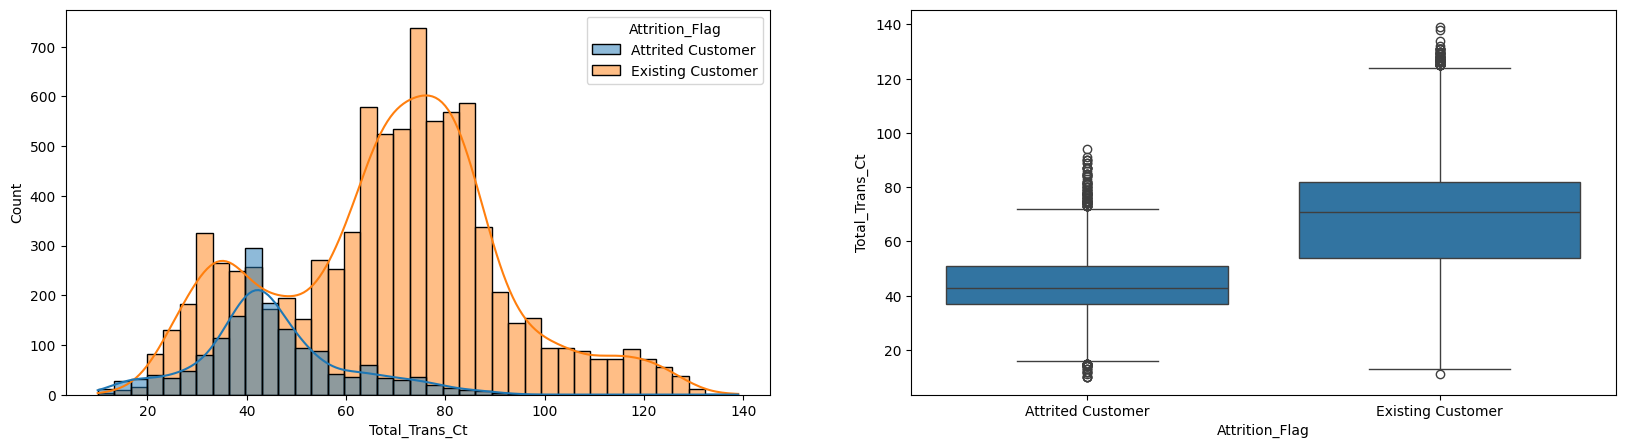

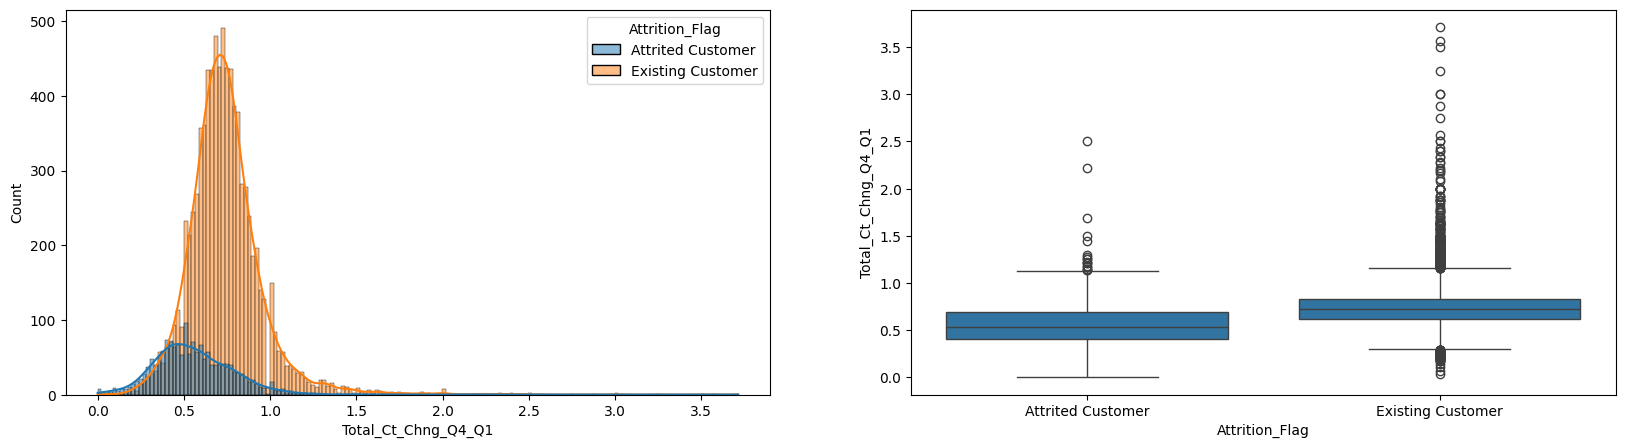

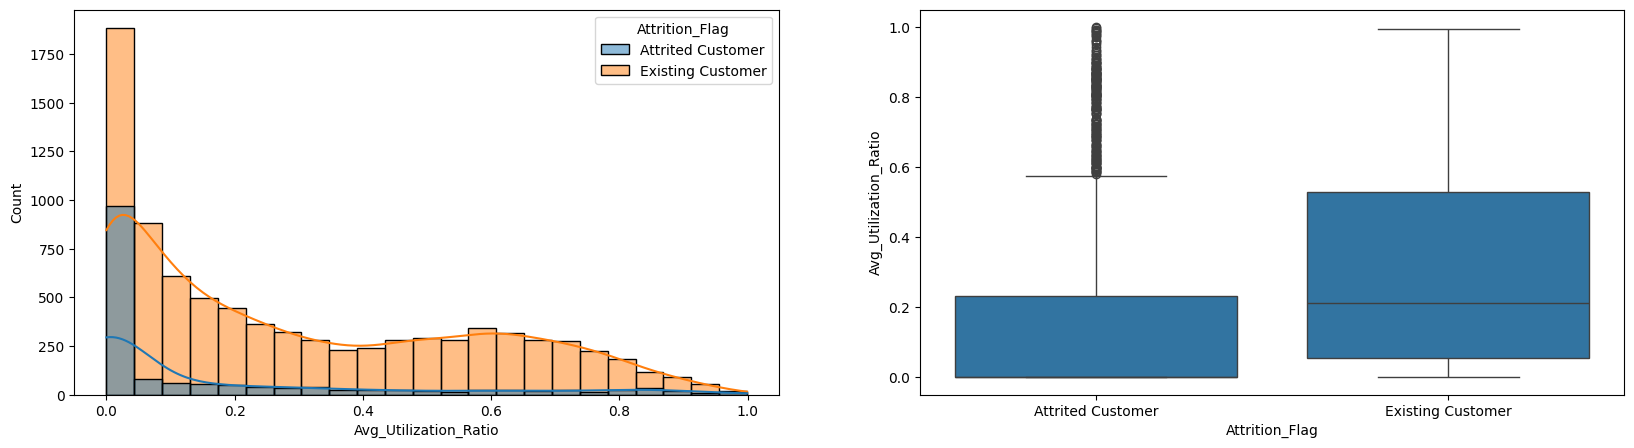

In [20]:
def plot_box(var):
    plt.subplot(1, 2, 1)  # Met le graphique à gauche de l'écran
    sns.histplot(data=df, x=var, hue='Attrition_Flag', kde=True)  # kde=True permet de mettre la densité
    
    plt.subplot(1, 2, 2)  # Met le graphique à droite de l'écran
    sns.boxplot(x='Attrition_Flag', y=var, data=df)
    
    plt.show()

for col in numeric_columns.columns:
    plt.figure(figsize=(20, 5))
    plot_box(col)

**Total_Revolving_Bal, Total_Trans_Ct et Avg_Utilization_Ratio semble être des variables intéressantes dans l'analyse de l'attrition**

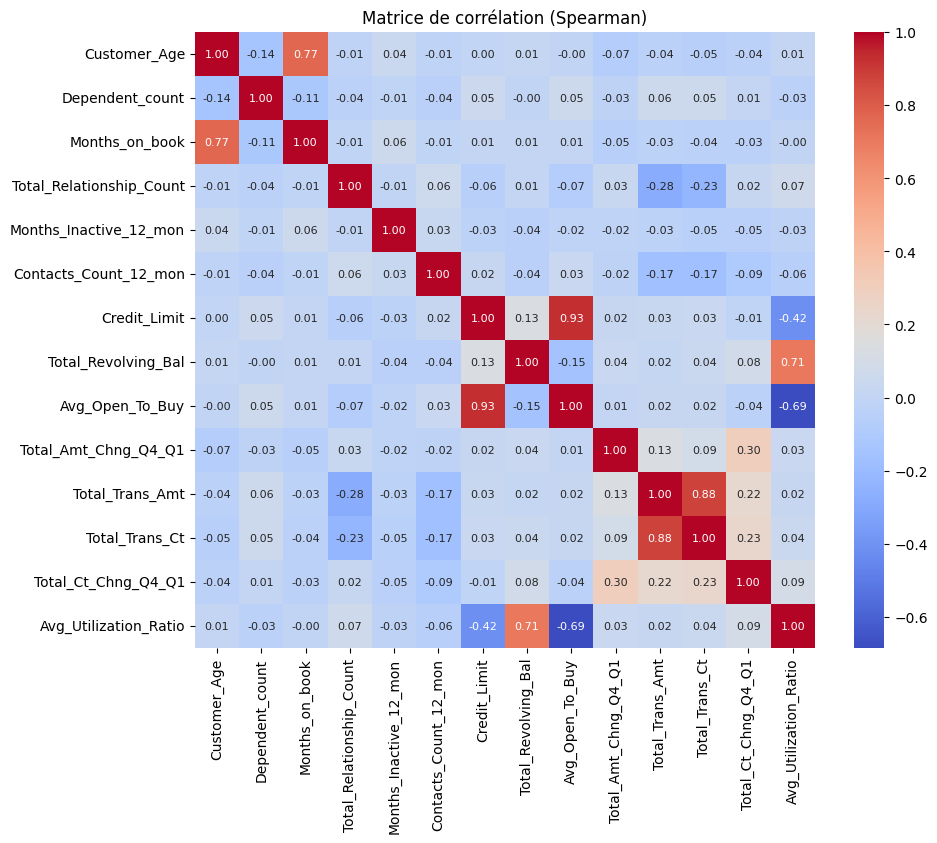

In [21]:
corr_matrix = numeric_columns.corr(method='spearman') # Pourquoi utiliser Spearman ?

plt.figure(figsize=(10, 8))

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 8})
plt.title('Matrice de corrélation (Spearman)')
plt.show()

Grâce à cette représentation graphique on voit que certaines variables semblent corrélées entre elles :
* ***Month_on_book*** et ***Customer_Age*** => 0.77
* ***Total_Trans_Ct*** et ***Total_Trans_Amt*** => 0.88
* ***Total_Revolving_Bal*** et ***Avg_utilzation_Ratio*** => 0.71
* ***Avg_Open_To_Buy*** et ***Credit_Limit*** => 0.93

Les boxplot entre Avg_Open_To_Buy et Credit_Limit ne varient pas en fonction de l'attrition ou non, donc on peut supprimer une des deux. On supprime Total_Trans_Ct car la variable Avg_Utilization_Ration correspond déjà à un critère de nombre de transaction

In [7]:
numeric_columns = df.select_dtypes(include=['int64', 'float64'])

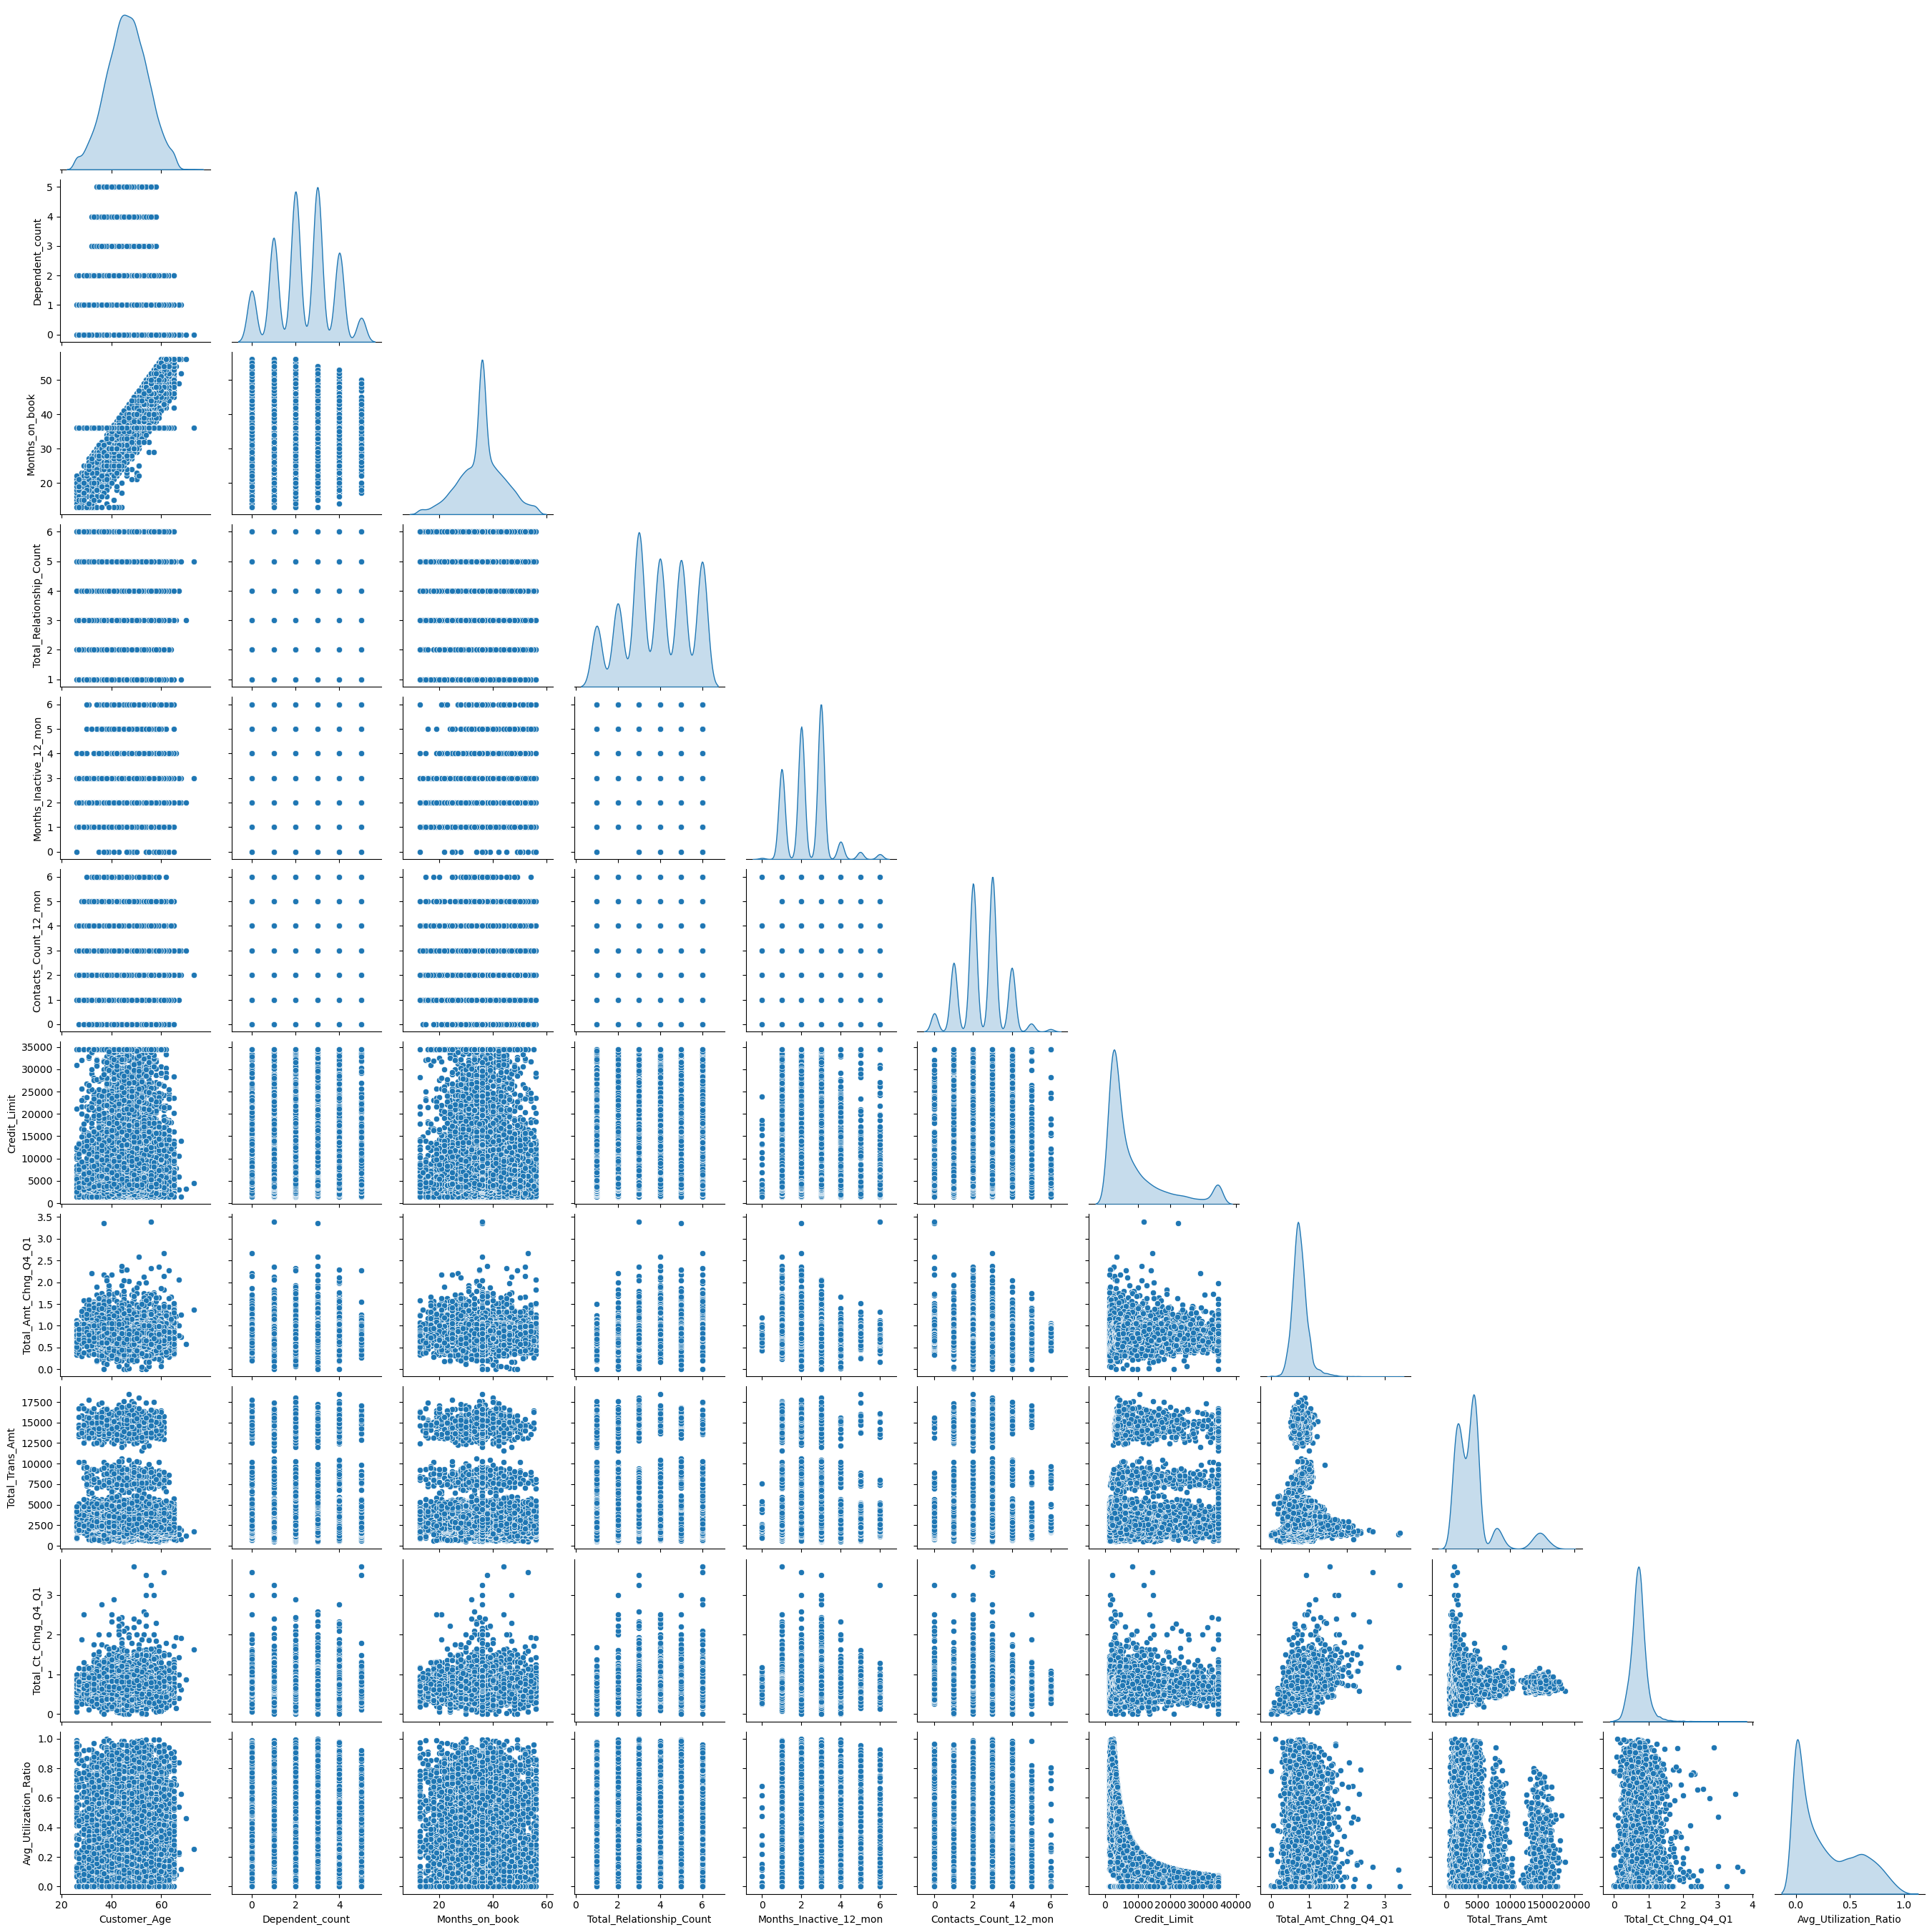

In [19]:
sns.pairplot(numeric_columns, corner=True, diag_kind="kde")

On observe une relation linéaire entre `Month_On_Book` et `Customer_Age`. On verra plus tard si on supprimer une des deux variables

# 3. Preprocessing 

https://www.kaggle.com/code/rebeccapringle/bank-churners-96-6-accuracy

In [52]:
X = df.drop(columns=['Attrition_Flag'])  
y = df['Attrition_Flag']  

In [9]:
""" X = df[["Contacts_Count_12_mon",
"Total_Relationship_Count",
"Total_Amt_Chng_Q4_Q1",
"Total_Ct_Chng_Q4_Q1",
"Total_Revolving_Bal",
"Total_Trans_Ct",
"Total_Trans_Amt"]] """

# X = df[['Total_Relationship_Count',
#        'Months_Inactive_12_mon',
#        'Contacts_Count_12_mon', 'Total_Revolving_Bal',
#        'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
#        'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1',
#        'Gender']]

In [53]:
y = df['Attrition_Flag']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [54]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8101, 18), (2026, 18), (8101,), (2026,))

## 3.1. Pipeline creation

In [55]:
X.head()

Customer_Age Gender  Dependent_count Education_Level Marital_Status  \
0            45      M                3     High School        Married   
1            49      F                5        Graduate         Single   
2            51      M                3        Graduate        Married   
3            40      F                4     High School        Unknown   
4            40      M                3      Uneducated        Married   

  Income_Category Card_Category  Months_on_book  Total_Relationship_Count  \
0     $60K - $80K          Blue              39                         5   
1  Less than $40K          Blue              44                         6   
2    $80K - $120K          Blue              36                         4   
3  Less than $40K          Blue              34                         3   
4     $60K - $80K          Blue              21                         5   

   Months_Inactive_12_mon  Contacts_Count_12_mon  Credit_Limit  \
0                       1                      3       12691.0   
1                       1                      2        8256.0   
2                       1                      0        3418.0   
3                       4                      1        3313.0   
4                       1                      0        4716.0   

   Total_Revolving_Bal  Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  \
0                  777          11914.0                 1.335   
1                  864           7392.0                 1.541   
2                    0           3418.0                 2.594   
3                 2517            796.0                 1.405   
4                    0           4716.0                 2.175   

   Total_Trans_Amt  Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  
0             1144              42                1.625  
1             1291              33                3.714  
2             1887              20                2.333  
3             1171              20                2.333  
4              816              28                2.500

In [60]:
numeric_features = X.select_dtypes(include=['int', 'float']).columns.tolist()
categorical_features = X.select_dtypes(include=['category', 'object']).columns.tolist()

In [61]:
len(numeric_features + categorical_features)

18

In [62]:
def preprocessing(X_train, X_test, var_to_trans, cat_columns):

    cat_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    numeric_tranformer = Pipeline(steps=[
        #('robust scaler', RobustScaler()),
        ('minmax', MinMaxScaler()),
        ('quantil', QuantileTransformer())
        #('Standard scaler', StandardScaler()),
        #('log', LogTransformer())
        #('power', PowerTransformer())
        #('YJ', PowerTransformer(method='yeo-johnson'))
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('RobScal', numeric_tranformer, var_to_trans),
            ('OHE', cat_transformer, cat_columns)
        ],
        remainder='passthrough'
    )

    pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

    X_train_trans = pipeline.fit_transform(X_train)
    X_test_trans = pipeline.transform(X_test)

    features_names = preprocessor.get_feature_names_out()

    return X_train_trans, X_test_trans, features_names

In [63]:
X_train_trans, X_test_trans, col_names = preprocessing(X_train, X_test, numeric_features, categorical_features)

In [64]:
col_names

array(['RobScal__Customer_Age', 'RobScal__Dependent_count',
       'RobScal__Months_on_book', 'RobScal__Total_Relationship_Count',
       'RobScal__Months_Inactive_12_mon',
       'RobScal__Contacts_Count_12_mon', 'RobScal__Credit_Limit',
       'RobScal__Total_Revolving_Bal', 'RobScal__Avg_Open_To_Buy',
       'RobScal__Total_Amt_Chng_Q4_Q1', 'RobScal__Total_Trans_Amt',
       'RobScal__Total_Trans_Ct', 'RobScal__Total_Ct_Chng_Q4_Q1',
       'OHE__Gender_F', 'OHE__Gender_M', 'OHE__Education_Level_College',
       'OHE__Education_Level_Doctorate', 'OHE__Education_Level_Graduate',
       'OHE__Education_Level_High School',
       'OHE__Education_Level_Post-Graduate',
       'OHE__Education_Level_Uneducated', 'OHE__Education_Level_Unknown',
       'OHE__Marital_Status_Divorced', 'OHE__Marital_Status_Married',
       'OHE__Marital_Status_Single', 'OHE__Marital_Status_Unknown',
       'OHE__Income_Category_$120K +', 'OHE__Income_Category_$40K - $60K',
       'OHE__Income_Category_$60K - $8

In [65]:
# Création des dataframe intermédiaires pour avoir les colonnes transformées
X_train_trans_df = pd.DataFrame(X_train_trans, columns=col_names)
X_test_trans_df = pd.DataFrame(X_test_trans, columns=col_names)

In [66]:
y_train = y_train.map({'Attrited Customer': 1, 'Existing Customer': 0})
y_test = y_test.map({'Attrited Customer': 1, 'Existing Customer': 0})

# Test de plusieurs modèles :

In [67]:
models = [
    ('Random Forest', RandomForestClassifier()),
    ('Logistic Regression', LogisticRegression()),
    ('K-Nearest Neighbors', KNeighborsClassifier()),
    ('Support Vector Machine', SVC()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Naive Bayes', GaussianNB()),
    ('XGBoost', xgb.XGBClassifier()), 
    ('GradientBoosting', GradientBoostingClassifier())
]

In [68]:
for model_name, model in models:
    print(f"Training {model_name}...")
    model.fit(X_train_trans, y_train)
    y_pred = model.predict(X_test_trans)
    print(f"Classification Report for {model_name}:")
    print(classification_report(y_test, y_pred))
    print("----------------------------------------")

Training Random Forest...
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1699
           1       0.93      0.76      0.84       327

    accuracy                           0.95      2026
   macro avg       0.94      0.87      0.90      2026
weighted avg       0.95      0.95      0.95      2026

----------------------------------------
Training Logistic Regression...
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      1699
           1       0.78      0.57      0.66       327

    accuracy                           0.90      2026
   macro avg       0.85      0.77      0.80      2026
weighted avg       0.90      0.90      0.90      2026

----------------------------------------
Training K-Nearest Neighbors...
Classification Report for K-Nearest Neighbors:
              precision    recall  f1-s

Les arbres de décision et les méthodes de Boosting semblent des bonnes pistes de modèles a tester pour ce jeu de données

# Procédure d'évaluation

In [69]:
def evaluation(model):
    # Utilisation directe des variables globales sans les déclarer explicitement comme global
    model.fit(X_train_trans, y_train) 
    y_pred = model.predict(X_test_trans)
    
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    
    train_sizes = np.linspace(0.1, 1.0, 20)
    
    N, train_scores, val_scores = learning_curve(model, X_train_trans, y_train,
                                                 cv=skf, scoring='f1',
                                                 train_sizes=train_sizes,
                                                 n_jobs=-1)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)
    
    plt.figure(figsize=(12, 8))
    plt.plot(N, train_scores_mean, label='Train score', color='blue')
    plt.fill_between(N, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color='blue')
    
    plt.plot(N, val_scores_mean, label='Validation score', color='green')
    plt.fill_between(N, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.2, color='green')
    
    plt.legend()
    plt.xlabel('Number of Training Samples')
    plt.ylabel('Score')
    plt.title('Learning Curve')
    plt.show()

In [70]:
# Visualisation de XGB par défaut
xgb_default = xgb.XGBClassifier(n_jobs=-1, random_state=0)

[[1664   35]
 [  38  289]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1699
           1       0.89      0.88      0.89       327

    accuracy                           0.96      2026
   macro avg       0.93      0.93      0.93      2026
weighted avg       0.96      0.96      0.96      2026



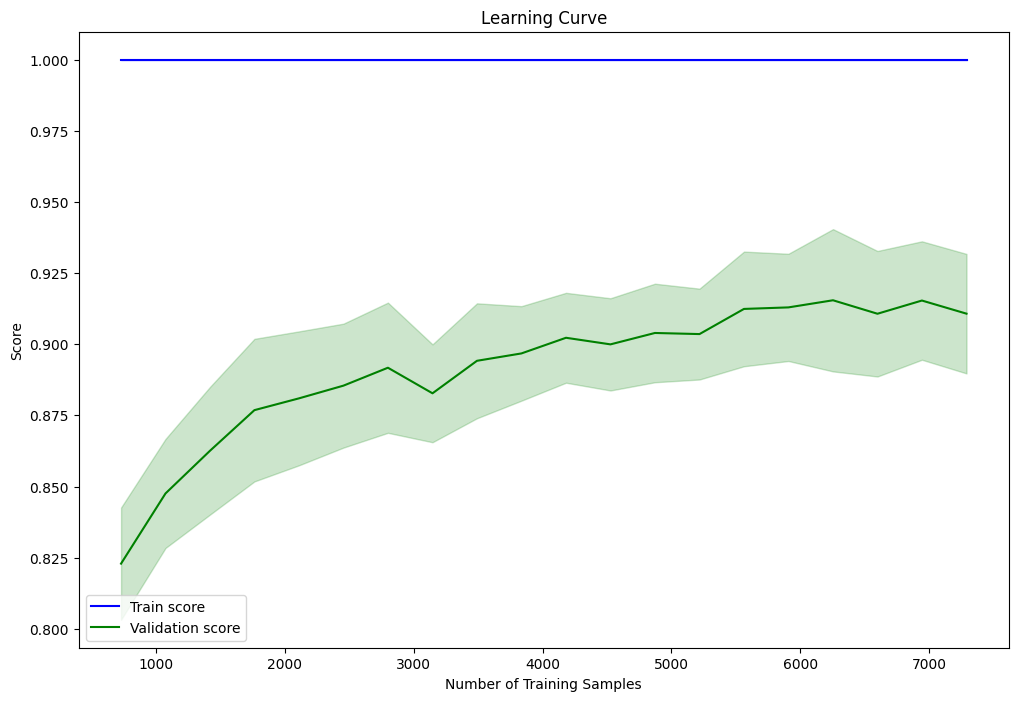

In [71]:
evaluation(xgb_default)

Situation d'overfitting très prononcée. On passe donc à une selection de variables pour réduire la dimensionnalité du jeu de données.

# Best features

In [77]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(f_classif, k=10)  
selector.fit_transform(X_train_trans, y_train) # sur X_train_trans car on veut connait les meilleures var sur les données transformées
np.array(X_train_trans_df.columns)[selector.get_support()] # sur X_train_num qui comporte les colonnes associées à X_train_trans

array(['RobScal__Total_Relationship_Count',
       'RobScal__Months_Inactive_12_mon',
       'RobScal__Contacts_Count_12_mon', 'RobScal__Credit_Limit',
       'RobScal__Total_Revolving_Bal', 'RobScal__Total_Amt_Chng_Q4_Q1',
       'RobScal__Total_Trans_Amt', 'RobScal__Total_Trans_Ct',
       'RobScal__Total_Ct_Chng_Q4_Q1', 'OHE__Gender_M'], dtype=object)

In [79]:
# Définir les modèles
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(solver='lbfgs', max_iter=1000),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'KNN': KNeighborsClassifier()
}

# Définir la fonction pour obtenir les 6 variables les plus importantes pour chaque modèle
def get_top_features(model, X_train, y_train, top_n=None):
    model.fit(X_train, y_train)
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_[0])
    else:
        # Utiliser la permutation importance pour les modèles qui n'ont pas d'attribut 'feature_importances_' ou 'coef_'
        result = permutation_importance(model, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2)
        importances = result.importances_mean
    
    top_features_indices = np.argsort(importances)[-top_n:]
    top_features = X_train_trans_df.columns[top_features_indices]
    return top_features

# Entraîner les modèles et obtenir les 3 variables les plus importantes pour chaque modèle
feature_counts = {}
for name, model in models.items():
    print(f"{name}:")
    
    # Entraîner le modèle avec toutes les fonctionnalités
    model.fit(X_train_trans, y_train)
    
    # Sélectionner les 3 meilleures caractéristiques
    top_features = get_top_features(model, X_train_trans, y_train, top_n=10)
    print(f"Top 6 features: {top_features}")
    
    # Calculer et afficher les scores de F1
    print(f"F1-score on training set: {f1_score(y_train, model.predict(X_train_trans)):.2f}")
    print(f"F1-score on test set: {f1_score(y_test, model.predict(X_test_trans)):.2f}")
    print("\n")

    # Compter le nombre de fois que chaque variable apparaît dans les 3 variables les plus importantes de chaque modèle
    for feature in top_features:
        if feature in feature_counts:
            feature_counts[feature] += 1
        else:
            feature_counts[feature] = 1

# Afficher les résultats
print("Feature counts in top 6:")
for feature, count in feature_counts.items():
    print(f"{feature}: {count}")


Random Forest:
Top 6 features: Index(['RobScal__Contacts_Count_12_mon', 'RobScal__Customer_Age',
       'RobScal__Credit_Limit', 'RobScal__Avg_Open_To_Buy',
       'RobScal__Total_Relationship_Count', 'RobScal__Total_Amt_Chng_Q4_Q1',
       'RobScal__Total_Ct_Chng_Q4_Q1', 'RobScal__Total_Revolving_Bal',
       'RobScal__Total_Trans_Ct', 'RobScal__Total_Trans_Amt'],
      dtype='object')
F1-score on training set: 1.00
F1-score on test set: 0.85


Gradient Boosting:
Top 6 features: Index(['OHE__Gender_M', 'RobScal__Contacts_Count_12_mon',
       'RobScal__Customer_Age', 'RobScal__Months_Inactive_12_mon',
       'RobScal__Total_Amt_Chng_Q4_Q1', 'RobScal__Total_Relationship_Count',
       'RobScal__Total_Ct_Chng_Q4_Q1', 'RobScal__Total_Revolving_Bal',
       'RobScal__Total_Trans_Amt', 'RobScal__Total_Trans_Ct'],
      dtype='object')
F1-score on training set: 0.93
F1-score on test set: 0.88


Logistic Regression:
Top 6 features: Index(['RobScal__Dependent_count', 'OHE__Card_Category_Gold'

## Nouveau modèle a partir des best features :

In [80]:
X = df[["Contacts_Count_12_mon",
"Total_Relationship_Count",
"Total_Amt_Chng_Q4_Q1",
"Total_Ct_Chng_Q4_Q1",
"Total_Revolving_Bal",
"Total_Trans_Ct",
"Total_Trans_Amt"]]

y = df['Attrition_Flag'] 

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [82]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8101, 7), (2026, 7), (8101,), (2026,))

In [83]:
numeric_features = X.select_dtypes(include=['int', 'float']).columns.tolist()
categorical_features = X.select_dtypes(include=['category', 'object']).columns.tolist()

In [86]:
X_train_trans, X_test_trans, col_names = preprocessing(X_train, X_test, numeric_features, categorical_features)

In [87]:
col_names

array(['RobScal__Contacts_Count_12_mon',
       'RobScal__Total_Relationship_Count',
       'RobScal__Total_Amt_Chng_Q4_Q1', 'RobScal__Total_Ct_Chng_Q4_Q1',
       'RobScal__Total_Revolving_Bal', 'RobScal__Total_Trans_Ct',
       'RobScal__Total_Trans_Amt'], dtype=object)

In [88]:
# Création des dataframe intermédiaires pour avoir les colonnes transformées
X_train_trans_df = pd.DataFrame(X_train_trans, columns=col_names)
X_test_trans_df = pd.DataFrame(X_test_trans, columns=col_names)

In [89]:
y_train = y_train.map({'Attrited Customer': 1, 'Existing Customer': 0})
y_test = y_test.map({'Attrited Customer': 1, 'Existing Customer': 0})

In [90]:
# Visualisation de XGB par défaut
xgb_default2 = xgb.XGBClassifier(n_jobs=-1, random_state=0)

[[1659   40]
 [  48  279]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1699
           1       0.87      0.85      0.86       327

    accuracy                           0.96      2026
   macro avg       0.92      0.91      0.92      2026
weighted avg       0.96      0.96      0.96      2026



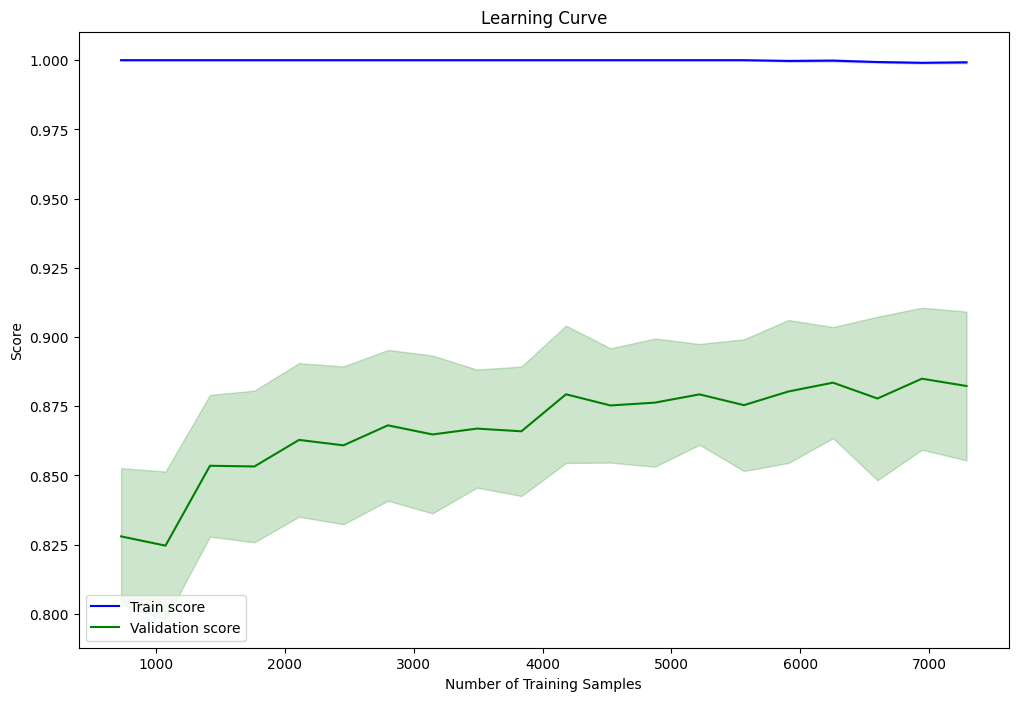

In [91]:
evaluation(xgb_default2)

On observe une extrêment légère descente du train score. On va passer à l'optimisation des hyperparamètres pour améliorer ces scores.

In [93]:
gb_default = GradientBoostingClassifier(random_state=42)

[[1674   25]
 [  55  272]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1699
           1       0.92      0.83      0.87       327

    accuracy                           0.96      2026
   macro avg       0.94      0.91      0.92      2026
weighted avg       0.96      0.96      0.96      2026



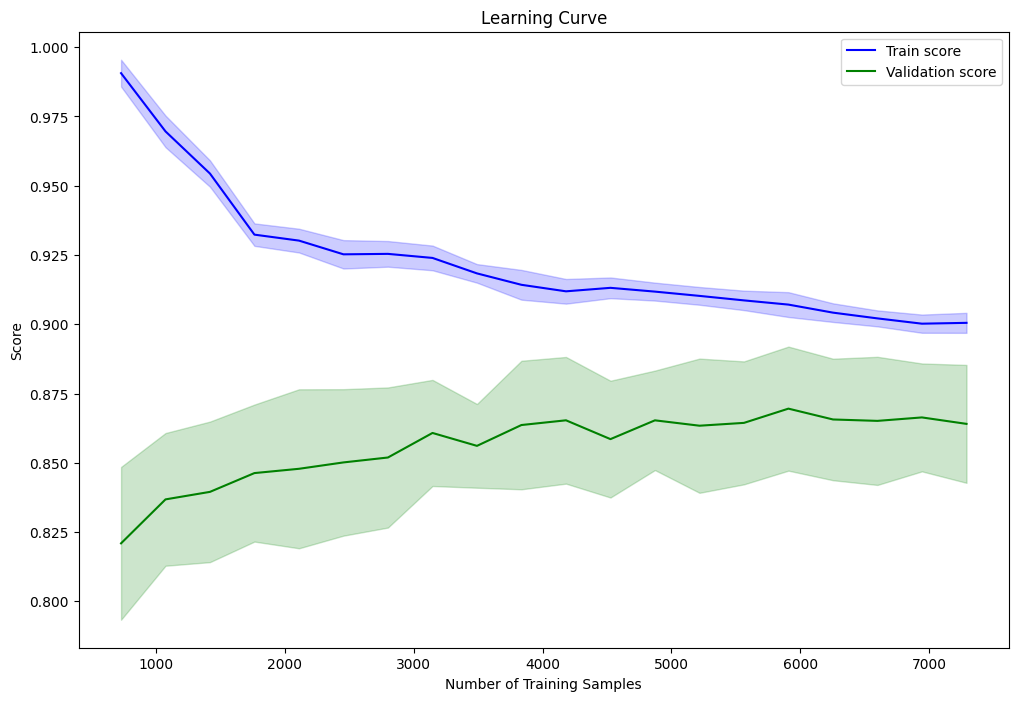

In [94]:
evaluation(gb_default)

Test : 0.9885199604732411
Train : 0.9932097655322181


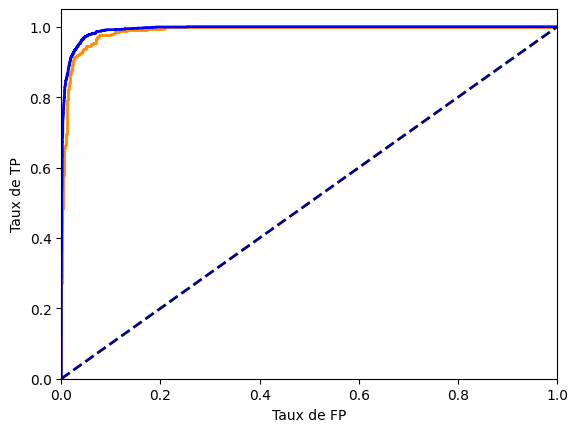

In [187]:
y_probs = gb_default.predict_proba(X_test_trans)[:, 1]
y_prob_train = gb_default.predict_proba(X_train_trans)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_probs)
fpr_train, tpr_train, _ = roc_curve(y_train, y_prob_train)

roc_auc = auc(fpr, tpr)
roc_auc_train = auc(fpr_train, tpr_train)

plt.figure()
lw = 2 
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='Courbe ROC (AUC = %0.2f)' % roc_auc)
plt.plot(fpr_train, tpr_train, color='blue', lw=lw, label='Courbe ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de FP')
plt.ylabel('Taux de TP')

print('Test :', roc_auc)
print('Train :', roc_auc_train)

In [188]:
df_results = pd.DataFrame({'y_probs' : y_probs, 'true': y_test})

df_results = df_results.sort_values(by='y_probs', ascending=False)

top_pred = df_results[0:int(len(y_test)*0.2)] # 20% des meilleures probabilités
nb_true_pos = top_pred[top_pred['true'] == 1].shape[0]
print('Parmi les 20% de meilleurs probabilités,', round(nb_true_pos / top_pred.shape[0] * 100, 2), '% de clients sont réellement souscripteurs')

Parmi les 20% de meilleurs probabilités, 76.3 % de clients sont réellement souscripteurs


In [189]:
data = pd.DataFrame({'y_true': y_test, 'y_probs': y_probs})
data = data.sort_values(by='y_probs', ascending=False).reset_index(drop=True)
data["rank"] = np.arange(1, len(data) + 1)
num_segm = 10
data["segment"] = pd.qcut(data['rank'], num_segm, labels=False)

# Convert 'y_true' to an integer data type
data['y_true'] = data['y_true'].astype(int)

lift_table = data.groupby('segment').agg({
    'y_true': ['sum', 'count']
}).reset_index()
lift_table.columns = ["segment", "sum_y_true", "count"]

In [190]:
lift_table

segment  sum_y_true  count
0        0         195    203
1        1         114    203
2        2          15    202
3        3           3    203
4        4           0    202
5        5           0    203
6        6           0    202
7        7           0    203
8        8           0    202
9        9           0    203

In [191]:
lift_table['cum_sub'] = lift_table['sum_y_true'].cumsum()
lift_table["cum_pop"] = lift_table['count'].cumsum() / len(data)

In [192]:
initial_point = pd.DataFrame({'segment': [-1], 'sum_y_true': [0], 'count': [0], 'cum_sub': [0], 'cum_pop': [0]})
lift_table = pd.concat([initial_point, lift_table]).reset_index(drop=True)

In [193]:
lift_table['perc_sub_capt_relatif'] = lift_table['cum_sub'] / lift_table['count'].cumsum()
lift_table['perc_sub_capt'] = lift_table['cum_sub'] / data['y_true'].sum()

In [194]:
lift_table

segment  sum_y_true  count  cum_sub   cum_pop  perc_sub_capt_relatif  \
0        -1           0      0        0  0.000000                    NaN   
1         0         195    203      195  0.100197               0.960591   
2         1         114    203      309  0.200395               0.761084   
3         2          15    202      324  0.300099               0.532895   
4         3           3    203      327  0.400296               0.403206   
5         4           0    202      327  0.500000               0.322804   
6         5           0    203      327  0.600197               0.268914   
7         6           0    202      327  0.699901               0.230606   
8         7           0    203      327  0.800099               0.201727   
9         8           0    202      327  0.899803               0.179375   
10        9           0    203      327  1.000000               0.161402   

    perc_sub_capt  
0        0.000000  
1        0.596330  
2        0.944954  
3        0.990826  
4        1.000000  
5        1.000000  
6        1.000000  
7        1.000000  
8        1.000000  
9        1.000000  
10       1.000000

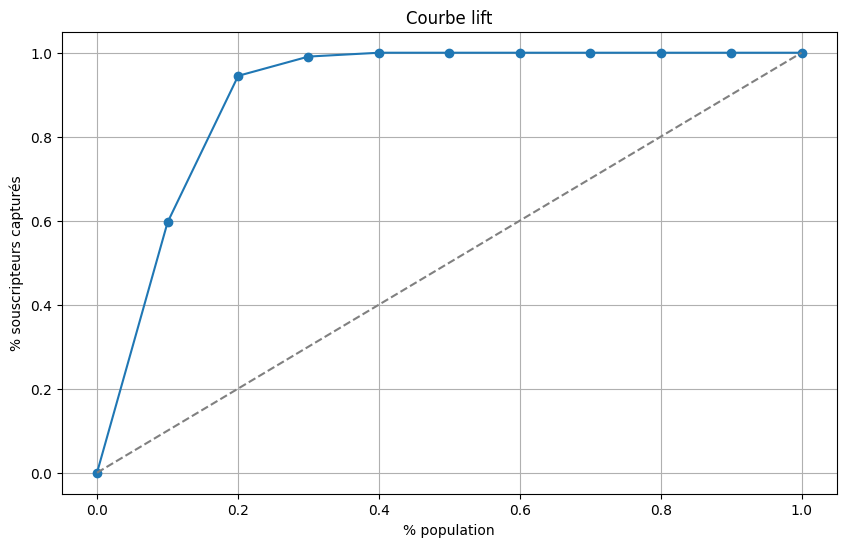

In [195]:
plt.figure(figsize=(10, 6))
x = lift_table["cum_pop"]
y = lift_table["perc_sub_capt"]

plt.plot(x, y, marker='o')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.title('Courbe lift')
plt.xlabel('% population')
plt.ylabel('% souscripteurs capturés')
plt.grid(True)
plt.show()

In [196]:
def lift(lift_table, pourcentage):
    return round(lift_table[lift_table['segment'] == (20 / 10) - 1]["perc_sub_capt"] / pourcentage * 100, 2)

In [197]:
lift(lift_table=lift_table, pourcentage=20)

2    4.72
Name: perc_sub_capt, dtype: float64

# GridSearchCV :

### XGB :

In [102]:
from sklearn.metrics import f1_score
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.05],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Définir le modèle XGBoost
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Définir la validation croisée
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Effectuer la recherche de grille avec sortie verbose
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=skf, scoring='f1', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Imprimer les meilleurs paramètres
print("Meilleurs paramètres :", grid_search.best_params_)

# Évaluer le modèle sur l'ensemble de test
y_pred = grid_search.predict(X_test)
f1_score_val = f1_score(y_test, y_pred)
print("F1_score sur l'ensemble de test : {:.2f}%".format(f1_score_val * 100))

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Meilleurs paramètres : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300, 'subsample': 0.9}
F1_score sur l'ensemble de test : 87.73%


In [105]:
grid_search.best_params_

{'colsample_bytree': 0.8,
 'learning_rate': 0.1,
 'max_depth': 4,
 'n_estimators': 300,
 'subsample': 0.9}

[[1668   31]
 [  43  284]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1699
           1       0.90      0.87      0.88       327

    accuracy                           0.96      2026
   macro avg       0.94      0.93      0.93      2026
weighted avg       0.96      0.96      0.96      2026



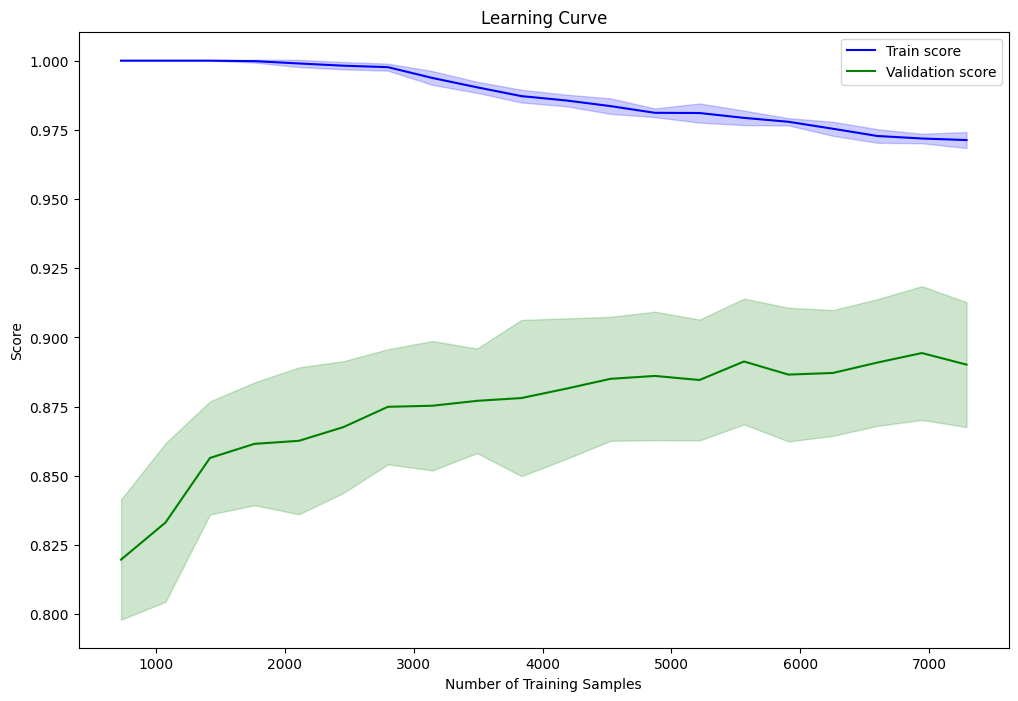

In [106]:
evaluation(xgb.XGBClassifier(colsample_bytree= 0.8, learning_rate= 0.1, max_depth= 4, n_estimators= 300, subsample= 0.9))

### GradientBoosting :

In [109]:
# Définir les paramètres de la grille de recherche
param_grid = {
    'learning_rate': [0.1, 0.01, 0.05],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'loss': ['log_loss', 'exponential']
}

# Définir le modèle Gradient Boosting
gb_model = GradientBoostingClassifier(random_state=42)

# Définir la validation croisée
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Effectuer la recherche de grille avec sortie verbose
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=skf, scoring='f1', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Imprimer les meilleurs paramètres
print("Meilleurs paramètres :", grid_search.best_params_)

# Évaluer le modèle sur l'ensemble de test
y_pred = grid_search.predict(X_test)
f1_score_val = f1_score(y_test, y_pred, average='binary')
print("F1_score sur l'ensemble de test : {:.2f}%".format(f1_score_val * 100))

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Meilleurs paramètres : {'learning_rate': 0.1, 'loss': 'exponential', 'max_depth': 4, 'n_estimators': 300, 'subsample': 0.8}
F1_score sur l'ensemble de test : 87.50%


In [110]:
test = GradientBoostingClassifier(learning_rate= 0.1, loss= 'exponential', max_depth= 4, n_estimators= 300, subsample= 0.8)

[[1667   32]
 [  47  280]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1699
           1       0.90      0.86      0.88       327

    accuracy                           0.96      2026
   macro avg       0.94      0.92      0.93      2026
weighted avg       0.96      0.96      0.96      2026



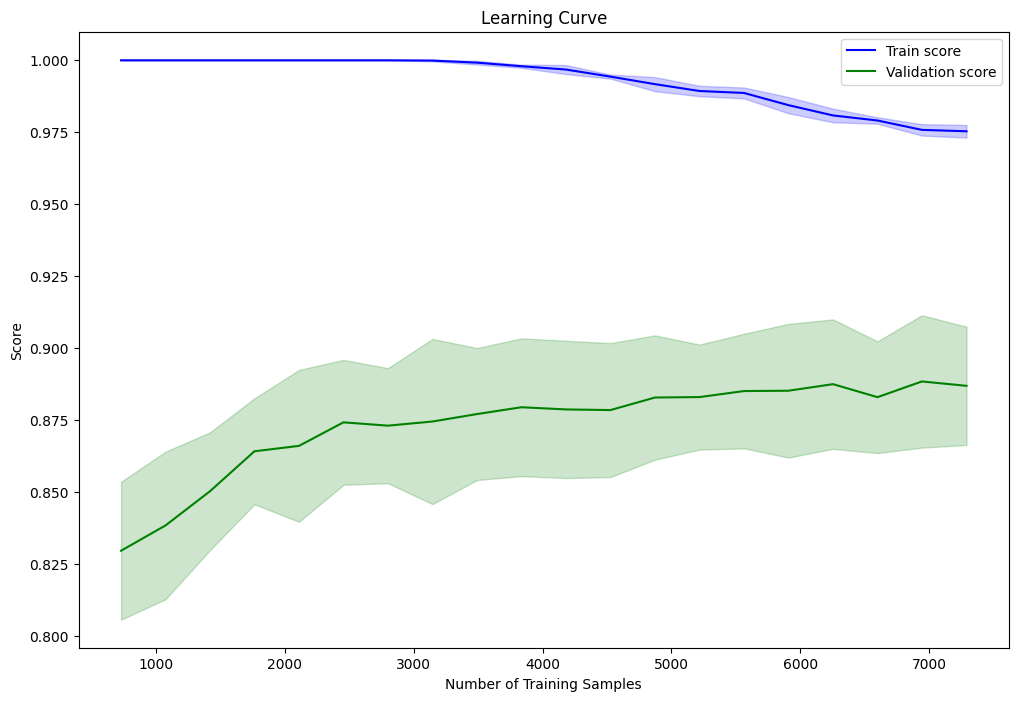

In [111]:
evaluation(test)

# Optuna XGB

In [112]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

train_x, val_x, train_y, val_y = train_test_split(X_train_trans, y_train, train_size=0.7, random_state=1)

In [113]:
def objective(trial):
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'booster': 'gbtree',
        'max_depth': trial.suggest_int('max_depth', 1, 3),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'seed': 0
    }

    model = xgb.XGBClassifier(**param)

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    fit_params = {
        'verbose': False,
        'eval_set': [(val_x, val_y)],
        'early_stopping_rounds': 10  
    }
    f1 = cross_val_score(model, X_train_trans, y_train, cv=skf, scoring=make_scorer(f1_score), fit_params=fit_params).mean()

    return f1


In [114]:
import optuna
from optuna.samplers import TPESampler

sampler = TPESampler(seed = 0) # Bayésien
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=200)

[I 2024-07-16 19:53:54,525] A new study created in memory with name: no-name-b5318452-da07-45c6-807f-37b8591a9a4d


[I 2024-07-16 19:53:56,392] Trial 0 finished with value: 0.8742702110455433 and parameters: {'max_depth': 2, 'learning_rate': 0.21740491624800165, 'n_estimators': 201, 'subsample': 0.7724415914984484, 'colsample_bytree': 0.7118273996694524, 'min_child_weight': 7, 'reg_alpha': 3.167361913032263e-05, 'reg_lambda': 0.13620216352659412}. Best is trial 0 with value: 0.8742702110455433.
[I 2024-07-16 19:53:58,360] Trial 1 finished with value: 0.8807970493870103 and parameters: {'max_depth': 3, 'learning_rate': 0.12119804045947552, 'n_estimators': 248, 'subsample': 0.7644474598764522, 'colsample_bytree': 0.7840222805469661, 'min_child_weight': 10, 'reg_alpha': 3.70073907377613e-08, 'reg_lambda': 4.9777650902423137e-08}. Best is trial 1 with value: 0.8807970493870103.
[I 2024-07-16 19:54:00,502] Trial 2 finished with value: 0.8417349454796668 and parameters: {'max_depth': 1, 'learning_rate': 0.251459755208902, 'n_estimators': 245, 'subsample': 0.9350060741234096, 'colsample_bytree': 0.98930917

In [115]:
print('Best trial:')
trial = study.best_trial
print('precision: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

Best trial:
precision: 0.8965569735100554
Best hyperparameters: {'max_depth': 2, 'learning_rate': 0.2618248445425998, 'n_estimators': 261, 'subsample': 0.9839816396267502, 'colsample_bytree': 0.8738896698259666, 'min_child_weight': 1, 'reg_alpha': 0.024106040491211397, 'reg_lambda': 0.08545335850218197}


In [116]:
best_params = trial.params 
xgb_opt = xgb.XGBClassifier(**best_params)

[[1665   34]
 [  42  285]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1699
           1       0.89      0.87      0.88       327

    accuracy                           0.96      2026
   macro avg       0.93      0.93      0.93      2026
weighted avg       0.96      0.96      0.96      2026



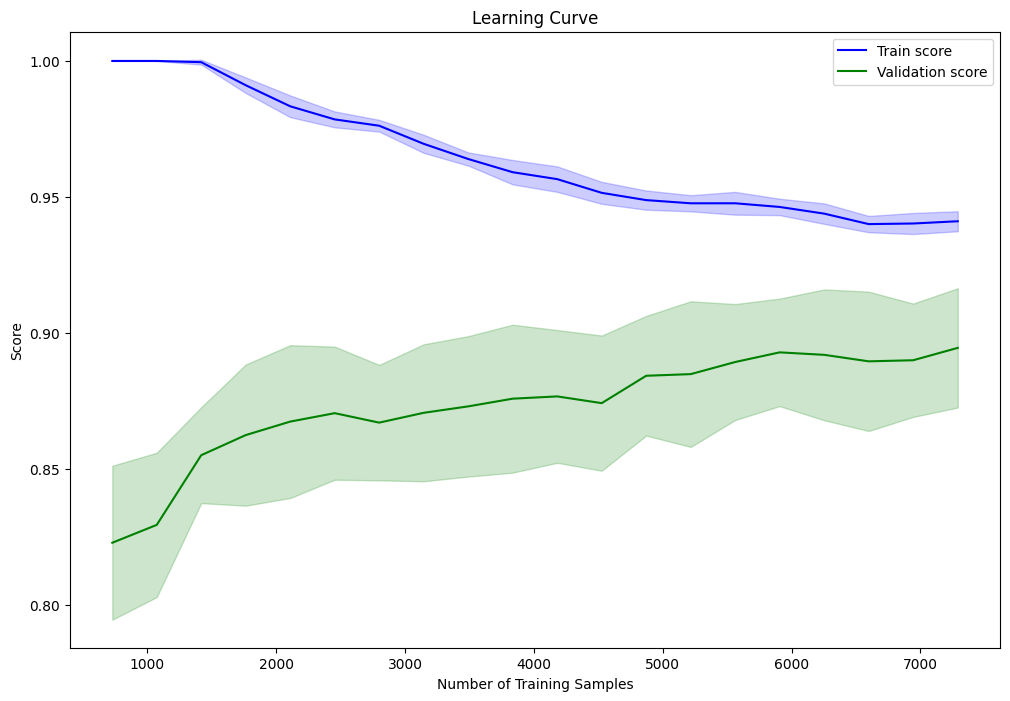

In [117]:
evaluation(xgb_opt)

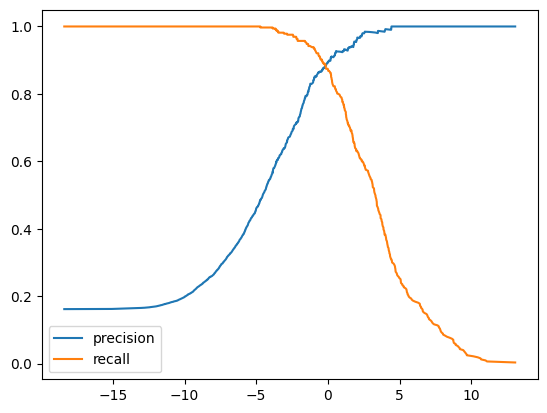

In [134]:
from sklearn.metrics import precision_recall_curve

precision, recall, threshold = precision_recall_curve(y_test, xgb_opt.predict(X_test_trans, output_margin=True))

plt.plot(threshold, precision[:-1], label='precision')
plt.plot(threshold, recall[:-1], label='recall')
plt.legend()

In [135]:
def model_final(model, X_train_trans, threshold=0):
    return model.predict(X_test_trans, output_margin=True) > threshold

In [161]:
y_pred = model_final(xgb_opt, X_test_trans, threshold=-0.61)

In [162]:
f1_score(y_true=y_test, y_pred=y_pred)

0.8882265275707899

Test : 0.9894883300664359
Train : 0.9971420492461516


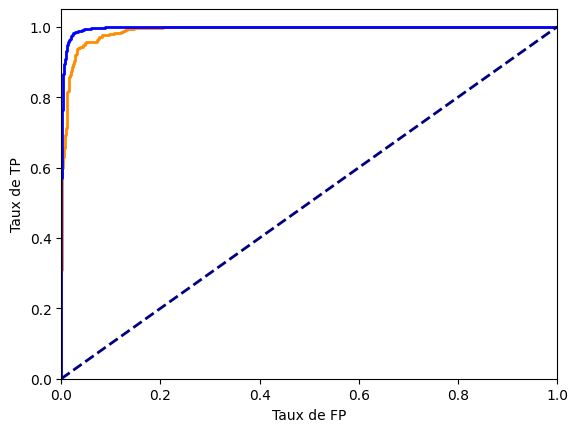

In [163]:
y_probs = xgb_opt.predict_proba(X_test_trans)[:, 1]
y_prob_train = xgb_opt.predict_proba(X_train_trans)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_probs)
fpr_train, tpr_train, _ = roc_curve(y_train, y_prob_train)

roc_auc = auc(fpr, tpr)
roc_auc_train = auc(fpr_train, tpr_train)

plt.figure()
lw = 2 
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='Courbe ROC (AUC = %0.2f)' % roc_auc)
plt.plot(fpr_train, tpr_train, color='blue', lw=lw, label='Courbe ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de FP')
plt.ylabel('Taux de TP')

print('Test :', roc_auc)
print('Train :', roc_auc_train)

In [166]:
df_results = pd.DataFrame({'y_probs' : y_probs, 'true': y_test})

df_results = df_results.sort_values(by='y_probs', ascending=False)

top_pred = df_results[0:int(len(y_test)*0.2)] # 20% des meilleures probabilités
nb_true_pos = top_pred[top_pred['true'] == 1].shape[0]
print('Parmi les 20% de meilleurs probabilités,', round(nb_true_pos / top_pred.shape[0] * 100, 2), '% de clients sont réellement souscripteurs')

Parmi les 20% de meilleurs probabilités, 77.28 % de clients sont réellement souscripteurs


In [167]:
data = pd.DataFrame({'y_true': y_test, 'y_probs': y_probs})
data = data.sort_values(by='y_probs', ascending=False).reset_index(drop=True)
data["rank"] = np.arange(1, len(data) + 1)
num_segm = 10
data["segment"] = pd.qcut(data['rank'], num_segm, labels=False)

# Convert 'y_true' to an integer data type
data['y_true'] = data['y_true'].astype(int)

lift_table = data.groupby('segment').agg({
    'y_true': ['sum', 'count']
}).reset_index()
lift_table.columns = ["segment", "sum_y_true", "count"]

In [168]:
lift_table

segment  sum_y_true  count
0        0         197    203
1        1         116    203
2        2          13    202
3        3           1    203
4        4           0    202
5        5           0    203
6        6           0    202
7        7           0    203
8        8           0    202
9        9           0    203

In [169]:
lift_table['cum_sub'] = lift_table['sum_y_true'].cumsum()
lift_table["cum_pop"] = lift_table['count'].cumsum() / len(data)

In [170]:
initial_point = pd.DataFrame({'segment': [-1], 'sum_y_true': [0], 'count': [0], 'cum_sub': [0], 'cum_pop': [0]})
lift_table = pd.concat([initial_point, lift_table]).reset_index(drop=True)

In [171]:
lift_table['perc_sub_capt_relatif'] = lift_table['cum_sub'] / lift_table['count'].cumsum()
lift_table['perc_sub_capt'] = lift_table['cum_sub'] / data['y_true'].sum()

In [172]:
lift_table

segment  sum_y_true  count  cum_sub   cum_pop  perc_sub_capt_relatif  \
0        -1           0      0        0  0.000000                    NaN   
1         0         197    203      197  0.100197               0.970443   
2         1         116    203      313  0.200395               0.770936   
3         2          13    202      326  0.300099               0.536184   
4         3           1    203      327  0.400296               0.403206   
5         4           0    202      327  0.500000               0.322804   
6         5           0    203      327  0.600197               0.268914   
7         6           0    202      327  0.699901               0.230606   
8         7           0    203      327  0.800099               0.201727   
9         8           0    202      327  0.899803               0.179375   
10        9           0    203      327  1.000000               0.161402   

    perc_sub_capt  
0        0.000000  
1        0.602446  
2        0.957187  
3        0.996942  
4        1.000000  
5        1.000000  
6        1.000000  
7        1.000000  
8        1.000000  
9        1.000000  
10       1.000000

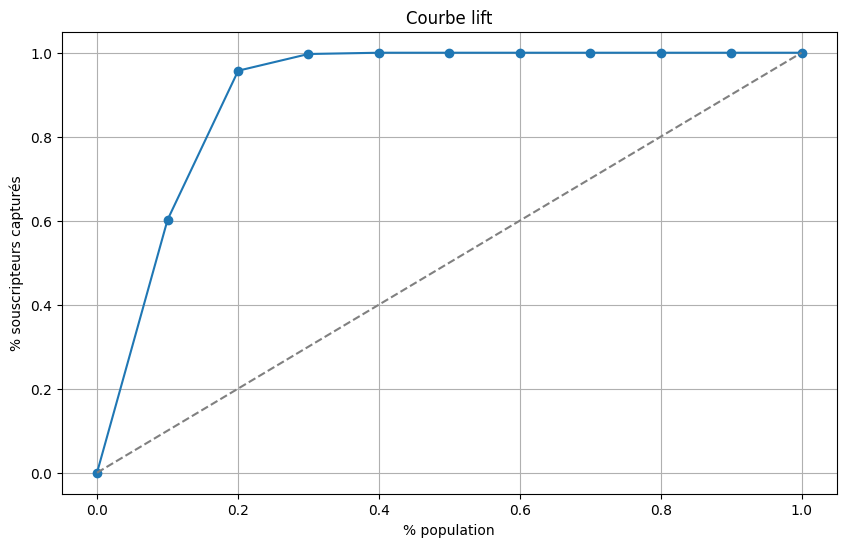

In [173]:
plt.figure(figsize=(10, 6))
x = lift_table["cum_pop"]
y = lift_table["perc_sub_capt"]

plt.plot(x, y, marker='o')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.title('Courbe lift')
plt.xlabel('% population')
plt.ylabel('% souscripteurs capturés')
plt.grid(True)
plt.show()

In [174]:
def lift(lift_table, pourcentage):
    return round(lift_table[lift_table['segment'] == (20 / 10) - 1]["perc_sub_capt"] / pourcentage * 100, 2)

In [175]:
lift(lift_table=lift_table, pourcentage=20)

2    4.79
Name: perc_sub_capt, dtype: float64

# Optuna GradientBoosting :

In [118]:
def objective(trial):
    param = {
        'loss': trial.suggest_categorical('loss', ['log_loss', 'exponential']),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'max_depth': trial.suggest_int('max_depth', 1, 3),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'min_weight_fraction_leaf': trial.suggest_float('min_weight_fraction_leaf', 0.0, 0.5),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'random_state': 0
    }

    model = GradientBoostingClassifier(**param)

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    f1 = cross_val_score(model, X_train_trans, y_train, cv=skf, scoring=make_scorer(f1_score)).mean()

    return f1

In [119]:
import optuna
from optuna.samplers import TPESampler

sampler = TPESampler(seed = 0) # Bayésien
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=100)

[I 2024-07-16 20:04:13,162] A new study created in memory with name: no-name-24eb1bdc-f77f-41ca-aaec-88581fde0855
[I 2024-07-16 20:04:17,281] Trial 0 finished with value: 0.4785352570938932 and parameters: {'loss': 'exponential', 'learning_rate': 0.18480137906077673, 'n_estimators': 186, 'subsample': 0.7118273996694524, 'max_depth': 2, 'min_samples_split': 10, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.48183138025051464, 'max_features': 'log2'}. Best is trial 0 with value: 0.4785352570938932.
[I 2024-07-16 20:04:18,809] Trial 1 finished with value: 0.5770396266710235 and parameters: {'loss': 'exponential', 'learning_rate': 0.2784230251048717, 'n_estimators': 67, 'subsample': 0.5435646498507704, 'max_depth': 1, 'min_samples_split': 17, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.4350060741234096, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.5770396266710235.
[I 2024-07-16 20:04:24,774] Trial 2 finished with value: 0.7816356511364564 and parameters: {'loss': 

In [120]:
print('Best trial:')
trial_2 = study.best_trial
print('precision: {}'.format(trial_2.value))
print("Best hyperparameters: {}".format(trial_2.params))

Best trial:
precision: 0.8893219174993353
Best hyperparameters: {'loss': 'exponential', 'learning_rate': 0.20029605390658642, 'n_estimators': 296, 'subsample': 0.9874658738087737, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0022260437665095434, 'max_features': 'sqrt'}


In [121]:
best_params = trial_2.params 
gb_opt = GradientBoostingClassifier(**best_params)

[[1665   34]
 [  51  276]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1699
           1       0.89      0.84      0.87       327

    accuracy                           0.96      2026
   macro avg       0.93      0.91      0.92      2026
weighted avg       0.96      0.96      0.96      2026



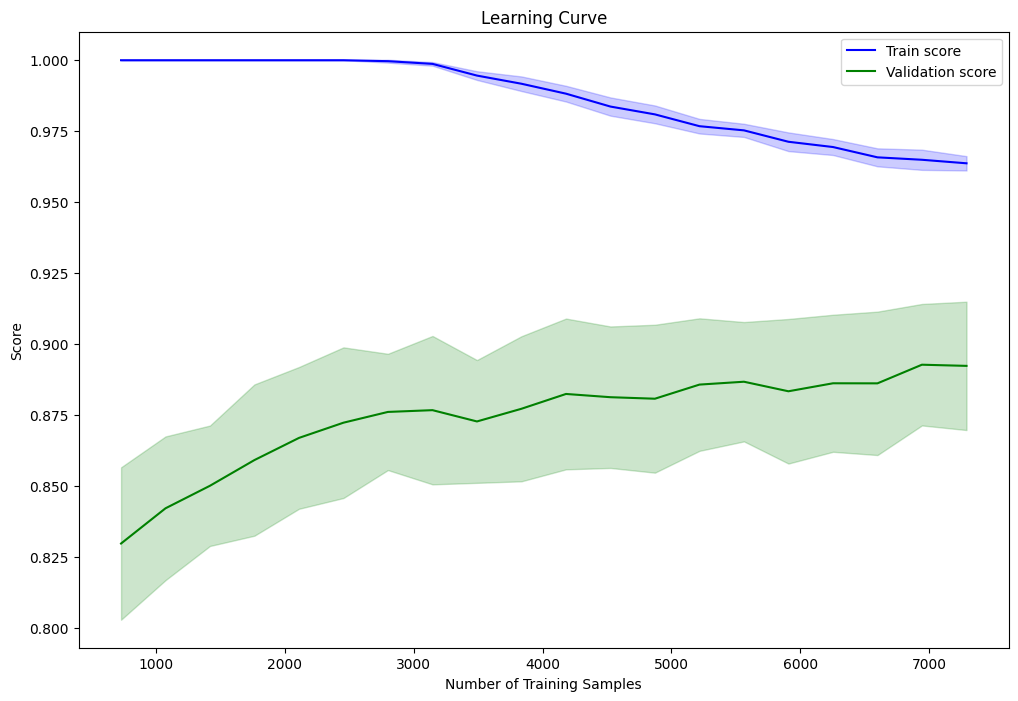

In [122]:
evaluation(gb_opt)

In [123]:
optuna.visualization.plot_param_importances(study)

In [124]:
optuna.visualization.plot_optimization_history(study)

Test : 0.9894271319880557
Train : 0.999109520093199


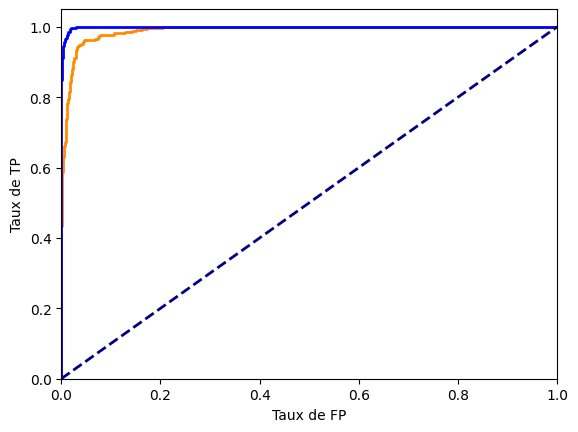

In [176]:
y_probs = gb_opt.predict_proba(X_test_trans)[:, 1]
y_prob_train = gb_opt.predict_proba(X_train_trans)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_probs)
fpr_train, tpr_train, _ = roc_curve(y_train, y_prob_train)

roc_auc = auc(fpr, tpr)
roc_auc_train = auc(fpr_train, tpr_train)

plt.figure()
lw = 2 
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='Courbe ROC (AUC = %0.2f)' % roc_auc)
plt.plot(fpr_train, tpr_train, color='blue', lw=lw, label='Courbe ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de FP')
plt.ylabel('Taux de TP')

print('Test :', roc_auc)
print('Train :', roc_auc_train)

In [177]:
df_results = pd.DataFrame({'y_probs' : y_probs, 'true': y_test})

df_results = df_results.sort_values(by='y_probs', ascending=False)

top_pred = df_results[0:int(len(y_test)*0.2)] # 20% des meilleures probabilités
nb_true_pos = top_pred[top_pred['true'] == 1].shape[0]
print('Parmi les 20% de meilleurs probabilités,', round(nb_true_pos / top_pred.shape[0] * 100, 2), '% de clients sont réellement souscripteurs')

Parmi les 20% de meilleurs probabilités, 77.78 % de clients sont réellement souscripteurs


In [178]:
data = pd.DataFrame({'y_true': y_test, 'y_probs': y_probs})
data = data.sort_values(by='y_probs', ascending=False).reset_index(drop=True)
data["rank"] = np.arange(1, len(data) + 1)
num_segm = 10
data["segment"] = pd.qcut(data['rank'], num_segm, labels=False)

# Convert 'y_true' to an integer data type
data['y_true'] = data['y_true'].astype(int)

lift_table = data.groupby('segment').agg({
    'y_true': ['sum', 'count']
}).reset_index()
lift_table.columns = ["segment", "sum_y_true", "count"]

In [179]:
lift_table

segment  sum_y_true  count
0        0         196    203
1        1         119    203
2        2          10    202
3        3           2    203
4        4           0    202
5        5           0    203
6        6           0    202
7        7           0    203
8        8           0    202
9        9           0    203

In [180]:
lift_table['cum_sub'] = lift_table['sum_y_true'].cumsum()
lift_table["cum_pop"] = lift_table['count'].cumsum() / len(data)

In [181]:
initial_point = pd.DataFrame({'segment': [-1], 'sum_y_true': [0], 'count': [0], 'cum_sub': [0], 'cum_pop': [0]})
lift_table = pd.concat([initial_point, lift_table]).reset_index(drop=True)

In [182]:
lift_table['perc_sub_capt_relatif'] = lift_table['cum_sub'] / lift_table['count'].cumsum()
lift_table['perc_sub_capt'] = lift_table['cum_sub'] / data['y_true'].sum()

In [183]:
lift_table

segment  sum_y_true  count  cum_sub   cum_pop  perc_sub_capt_relatif  \
0        -1           0      0        0  0.000000                    NaN   
1         0         196    203      196  0.100197               0.965517   
2         1         119    203      315  0.200395               0.775862   
3         2          10    202      325  0.300099               0.534539   
4         3           2    203      327  0.400296               0.403206   
5         4           0    202      327  0.500000               0.322804   
6         5           0    203      327  0.600197               0.268914   
7         6           0    202      327  0.699901               0.230606   
8         7           0    203      327  0.800099               0.201727   
9         8           0    202      327  0.899803               0.179375   
10        9           0    203      327  1.000000               0.161402   

    perc_sub_capt  
0        0.000000  
1        0.599388  
2        0.963303  
3        0.993884  
4        1.000000  
5        1.000000  
6        1.000000  
7        1.000000  
8        1.000000  
9        1.000000  
10       1.000000

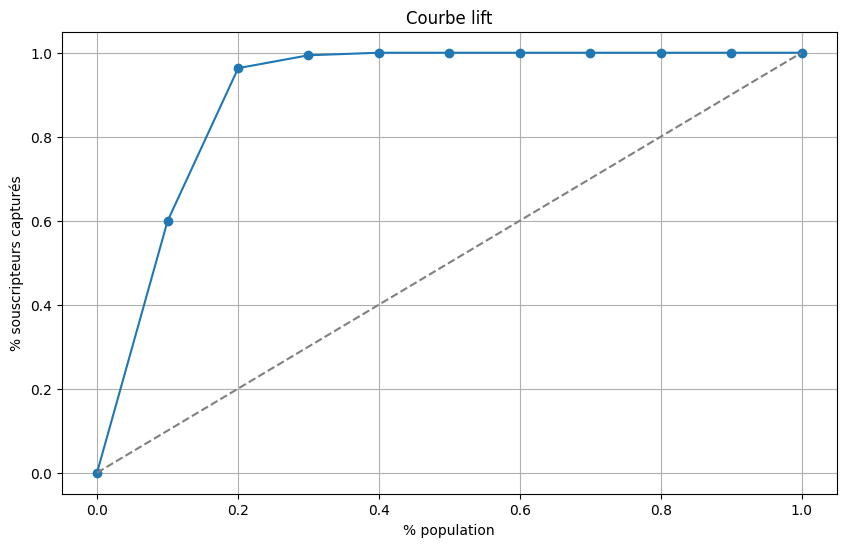

In [184]:
plt.figure(figsize=(10, 6))
x = lift_table["cum_pop"]
y = lift_table["perc_sub_capt"]

plt.plot(x, y, marker='o')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.title('Courbe lift')
plt.xlabel('% population')
plt.ylabel('% souscripteurs capturés')
plt.grid(True)
plt.show()

In [185]:
def lift(lift_table, pourcentage):
    return round(lift_table[lift_table['segment'] == (20 / 10) - 1]["perc_sub_capt"] / pourcentage * 100, 2)

In [186]:
lift(lift_table=lift_table, pourcentage=20)

2    4.82
Name: perc_sub_capt, dtype: float64

# Ancien Optuna

In [47]:
train_x, val_x, train_y, val_y = train_test_split(X_train_trans, y_train, train_size=0.7, random_state=1)

In [262]:
def objective(trial):
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'booster': 'gbtree',
        'max_depth': trial.suggest_int('max_depth', 1, 5),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'seed': 0
    }

    model = xgb.XGBClassifier(**param)

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    fit_params = {
        'verbose': False,
        'eval_set': [(val_x, val_y)],
        'early_stopping_rounds': 10  
    }
    f1 = cross_val_score(model, X_train_trans, y_train, cv=skf, scoring=make_scorer(f1_score), fit_params=fit_params).mean()

    return f1

In [267]:
import optuna
from optuna.samplers import TPESampler

sampler = TPESampler(seed = 0) # Bayésien
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=200)

[I 2024-07-04 20:37:08,879] A new study created in memory with name: no-name-7d3eea5a-5188-4bb9-9a60-6cd01bf0d0da
[I 2024-07-04 20:37:11,844] Trial 0 finished with value: 0.8924557575027728 and parameters: {'max_depth': 3, 'learning_rate': 0.21740491624800165, 'n_estimators': 201, 'subsample': 0.7724415914984484, 'colsample_bytree': 0.7118273996694524, 'min_child_weight': 7, 'reg_alpha': 3.167361913032263e-05, 'reg_lambda': 0.13620216352659412}. Best is trial 0 with value: 0.8924557575027728.
[I 2024-07-04 20:37:14,665] Trial 1 finished with value: 0.8903626825175746 and parameters: {'max_depth': 5, 'learning_rate': 0.12119804045947552, 'n_estimators': 248, 'subsample': 0.7644474598764522, 'colsample_bytree': 0.7840222805469661, 'min_child_weight': 10, 'reg_alpha': 3.70073907377613e-08, 'reg_lambda': 4.9777650902423137e-08}. Best is trial 0 with value: 0.8924557575027728.
[I 2024-07-04 20:37:16,372] Trial 2 finished with value: 0.8613011744242401 and parameters: {'max_depth': 1, 'learn

In [270]:
print('Best trial:')
trial = study.best_trial
print('f1_score: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

Best trial:
precision: 0.9078315190714743
Best hyperparameters: {'max_depth': 2, 'learning_rate': 0.22127198519345317, 'n_estimators': 255, 'subsample': 0.9886329621849067, 'colsample_bytree': 0.8632303857082904, 'min_child_weight': 1, 'reg_alpha': 0.0018213602377517024, 'reg_lambda': 0.03822074237262252}


In [271]:
best_params = trial.params 
model = xgb.XGBClassifier(**best_params)

In [47]:
xgb_opt = xgb.XGBClassifier(max_depth= 2, learning_rate= 0.22127198519345317, n_estimators= 255, subsample= 0.9886329621849067, colsample_bytree= 0.8632303857082904, 
                          min_child_weight= 1, reg_alpha= 0.0018213602377517024, reg_lambda= 0.03822074237262252, n_jobs=-1, random_state=0)

[[1668   31]
 [  39  288]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1699
           1       0.90      0.88      0.89       327

    accuracy                           0.97      2026
   macro avg       0.94      0.93      0.94      2026
weighted avg       0.97      0.97      0.97      2026



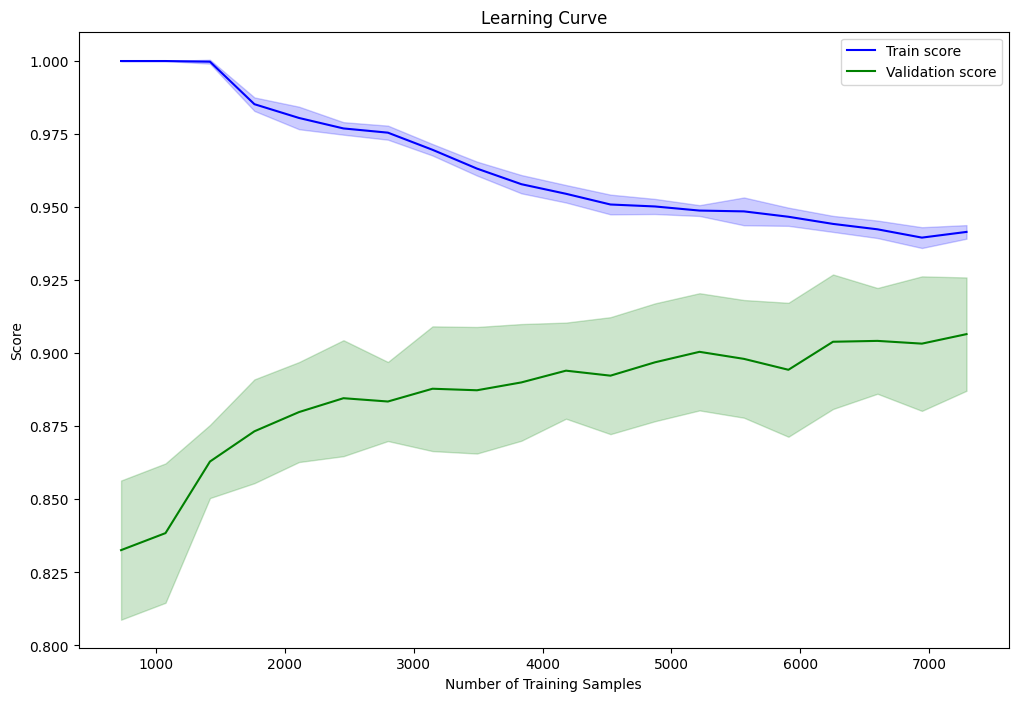

In [48]:
evaluation(xgb_opt)

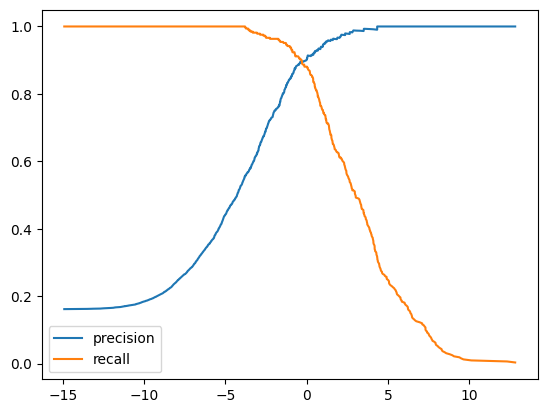

In [49]:
precision, recall, threshold = precision_recall_curve(y_test, xgb_opt.predict(X_test_trans, output_margin=True))

plt.plot(threshold, precision[:-1], label='precision')
plt.plot(threshold, recall[:-1], label='recall')
plt.legend()

In [50]:
def model_final(model, X_train_trans, threshold=0):
    return model.predict(X_test_trans, output_margin=True) > threshold

In [63]:
y_pred = model_final(model, X_test_trans, threshold=-0.55)

In [68]:
f1_score(y_true=y_test, y_pred=y_pred)

0.8989441930618401

Test : 0.9903523029376878
Train : 0.9967780756223632


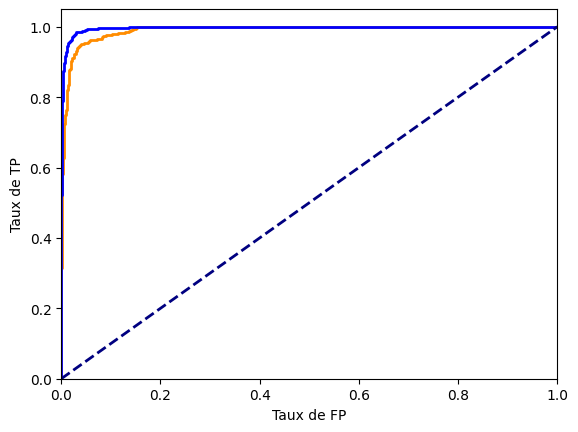

In [69]:
y_probs = xgb_opt.predict_proba(X_test_trans)[:, 1]
y_prob_train = xgb_opt.predict_proba(X_train_trans)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_probs)
fpr_train, tpr_train, _ = roc_curve(y_train, y_prob_train)

roc_auc = auc(fpr, tpr)
roc_auc_train = auc(fpr_train, tpr_train)

plt.figure()
lw = 2 
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='Courbe ROC (AUC = %0.2f)' % roc_auc)
plt.plot(fpr_train, tpr_train, color='blue', lw=lw, label='Courbe ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de FP')
plt.ylabel('Taux de TP')

print('Test :', roc_auc)
print('Train :', roc_auc_train)

In [85]:
df_results = pd.DataFrame({'y_probs' : y_probs, 'true': y_test})

df_results = df_results.sort_values(by='y_probs', ascending=False)

top_pred = df_results[0:405] # 20% des meilleures probabilités
nb_true_pos = top_pred[top_pred['true'] == 1].shape[0]
print('Parmi les 20% de meilleurs probabilités,', round(nb_true_pos / top_pred.shape[0] * 100, 2), '% de clients sont réellement souscripteurs')

Parmi les 20% de meilleurs probabilités, 77.28 % de clients sont réellement souscripteurs


In [77]:
data = pd.DataFrame({'y_true': y_test, 'y_probs': y_probs})
data = data.sort_values(by='y_probs', ascending=False).reset_index(drop=True)
data["rank"] = np.arange(1, len(data) + 1)
num_segm = 10
data["segment"] = pd.qcut(data['rank'], num_segm, labels=False)

# Convert 'y_true' to an integer data type
data['y_true'] = data['y_true'].astype(int)

lift_table = data.groupby('segment').agg({
    'y_true': ['sum', 'count']
}).reset_index()
lift_table.columns = ["segment", "sum_y_true", "count"]

In [78]:
lift_table

segment  sum_y_true  count
0        0         198    203
1        1         115    203
2        2          14    202
3        3           0    203
4        4           0    202
5        5           0    203
6        6           0    202
7        7           0    203
8        8           0    202
9        9           0    203

In [79]:
lift_table['cum_sub'] = lift_table['sum_y_true'].cumsum()
lift_table["cum_pop"] = lift_table['count'].cumsum() / len(data)

In [80]:
initial_point = pd.DataFrame({'segment': [-1], 'sum_y_true': [0], 'count': [0], 'cum_sub': [0], 'cum_pop': [0]})
lift_table = pd.concat([initial_point, lift_table]).reset_index(drop=True)

In [81]:
lift_table['perc_sub_capt_relatif'] = lift_table['cum_sub'] / lift_table['count'].cumsum()
lift_table['perc_sub_capt'] = lift_table['cum_sub'] / data['y_true'].sum()

In [82]:
lift_table

segment  sum_y_true  count  cum_sub   cum_pop  perc_sub_capt_relatif  \
0        -1           0      0        0  0.000000                    NaN   
1         0         198    203      198  0.100197               0.975369   
2         1         115    203      313  0.200395               0.770936   
3         2          14    202      327  0.300099               0.537829   
4         3           0    203      327  0.400296               0.403206   
5         4           0    202      327  0.500000               0.322804   
6         5           0    203      327  0.600197               0.268914   
7         6           0    202      327  0.699901               0.230606   
8         7           0    203      327  0.800099               0.201727   
9         8           0    202      327  0.899803               0.179375   
10        9           0    203      327  1.000000               0.161402   

    perc_sub_capt  
0        0.000000  
1        0.605505  
2        0.957187  
3        1.000000  
4        1.000000  
5        1.000000  
6        1.000000  
7        1.000000  
8        1.000000  
9        1.000000  
10       1.000000

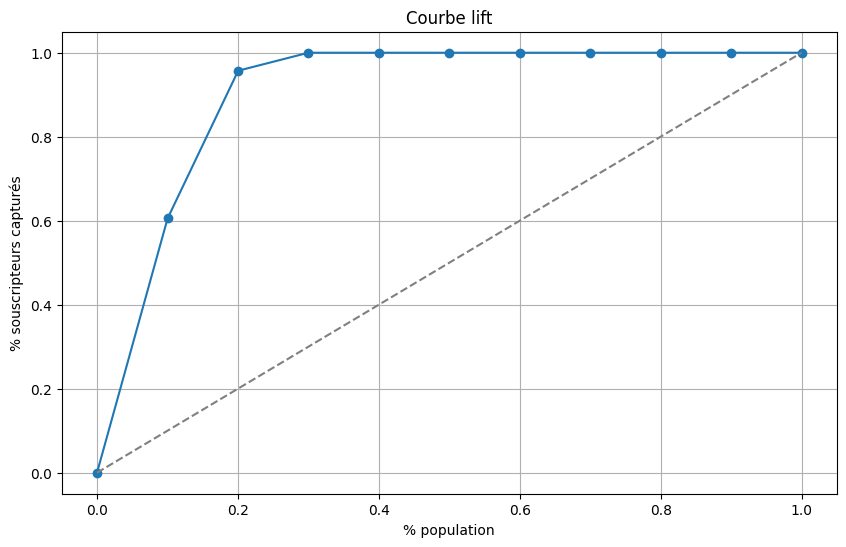

In [83]:
plt.figure(figsize=(10, 6))
x = lift_table["cum_pop"]
y = lift_table["perc_sub_capt"]

plt.plot(x, y, marker='o')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.title('Courbe lift')
plt.xlabel('% population')
plt.ylabel('% souscripteurs capturés')
plt.grid(True)
plt.show()

In [86]:
def lift(lift_table, pourcentage):
    return round(lift_table[lift_table['segment'] == (20 / 10) - 1]["perc_sub_capt"] / pourcentage * 100, 2)

In [87]:
lift(lift_table=lift_table, pourcentage=20)

2    4.79
Name: perc_sub_capt, dtype: float64